<a href="https://colab.research.google.com/github/cosminconstantincostea/RL_cosmincostea/blob/Reinforcement-Learning/v1_1_Baseline_vs_SAC_vs_DDPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline vs DDPG vs SAC  

In [ ]:
# TODO: update to install stable version from PyPi
!pip install --no-deps CityLearn==2.2b0

In [ ]:
!pip install nrel-pysam

# Prove standard RL algorithms
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 6.3 MB/s eta 0:00:00


In [ ]:
# import the necessary pacakages

# system operations
import inspect
import os
import uuid
import warnings

# date and time
import datetime

# type hinting
from typing import Any

# User interaction
from ipywidgets import Button, HTML
from ipywidgets import Text, HBox, VBox

# data visualization
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from tqdm import tqdm

# data manipulation
from bs4 import BeautifulSoup
import math
import numpy as np
import pandas as pd
import random
import re
import requests
import simplejson as json

# cityLearn
from citylearn.agents.base import (
    BaselineAgent,
    Agent as RandomAgent
)
from citylearn.agents.rbc import HourRBC
from citylearn.agents.q_learning import TabularQLearning
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction
from citylearn.wrappers import (
    NormalizedObservationWrapper,
    StableBaselines3Wrapper,
    TabularQLearningWrapper,
    DiscreteObservationWrapper,
    DiscreteActionWrapper
)

# RL algorithms
from stable_baselines3 import SAC
from stable_baselines3 import DQN
from stable_baselines3 import DDPG


# Callbacks
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3.common.callbacks import StopTrainingOnRewardThreshold
from stable_baselines3.common.callbacks import BaseCallback

import time

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Global settings for the remainder of the ote book

# All plotted figures without margins
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['axes.xmargin'] = 0
%matplotlib inline

# ignore depractino warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Dataset initializazion

Load alla the data set and display it

In [ ]:
display('All CityLearn datasets:', sorted(DataSet.get_names()))
DATASET_NAME = 'citylearn_challenge_2022_phase_1'

schema = DataSet.get_schema(DATASET_NAME)
root_directory = schema['root_directory']

'All CityLearn datasets:'

['baeda_3dem',
 'ca_alameda_county_neighborhood',
 'citylearn_challenge_2020_climate_zone_1',
 'citylearn_challenge_2020_climate_zone_2',
 'citylearn_challenge_2020_climate_zone_3',
 'citylearn_challenge_2020_climate_zone_4',
 'citylearn_challenge_2021',
 'citylearn_challenge_2022_phase_1',
 'citylearn_challenge_2022_phase_2',
 'citylearn_challenge_2022_phase_3',
 'citylearn_challenge_2022_phase_all',
 'citylearn_challenge_2023_phase_1',
 'citylearn_challenge_2023_phase_2_local_evaluation',
 'citylearn_challenge_2023_phase_2_online_evaluation_1',
 'citylearn_challenge_2023_phase_2_online_evaluation_2',
 'citylearn_challenge_2023_phase_2_online_evaluation_3',
 'citylearn_challenge_2023_phase_3_1',
 'citylearn_challenge_2023_phase_3_2',
 'citylearn_challenge_2023_phase_3_3',
 'tx_travis_county_neighborhood',
 'vt_chittenden_county_neighborhood']

### Environment
<figure class="image">
  <img src="https://github.com/intelligent-environments-lab/CityLearn/blob/master/assets/images/environment.jpg?raw=true"  width="800" alt="An overview of the heating, ventilation and air conditioning systems, energy storage systems, on-site electricity sources and grid interaction in buildings in the CityLearn environment." style="background-color:white;margin:20px;padding:5px">
  <figcaption>Figure: CityLearn building model including electricity sources that power controllable DERs including electric devices and ESSs, used to satisfy thermal and electrical loads as well as provide the grid with energy flexibility. A distinction is made between environment and control aspects of a building to show the transfer of actions from the control agent and reception of measurable observations by the control agent that quantifies the building's states (<a href="https://doi.org/10.48550/arXiv.2405.03848">Nweye et al., 2024</a>).</figcaption>
</figure>

CityLearn models a district of buildings with similar or different loads, electric devices, energy storage systems (ESSs) and electricity sources that satisfy the loads as shown in the figure above. There is no upper limit on the number of buildings in a district and a district can have as few as one building.

There are up to five loads ina building including:
- space cooling;
- space heating;
- domestic hot water (DHW) - all the hot water that a home needs;
- electric equipment - all the non-shiftable plug loads (lighting, entertainement, kitchen etc.);
- electric (EV) loads-

Building is modeled as single thermal zone where space thermal loads affect its indoor dry-bulb temperature. An occupant model has the ability to override the temperature setpoint.

Not all loads need to exist in a building.
Anyone or all of the loads are either known a priorii from building energy performance simulations (BEPS) or real-world measurements. In this instances the ideal load must be satisfied.
Alternatively, they are controlled loads and are inferred at runtime e.g., heat pump power control drives space cooling or heating loads.

To satisfy these loads in either the ideal or control-action case, CityLearn makes use of heating ventilation and air conditioning (HVAC) systems directly or ESSs through load shifting.
- The `cooling_device`, `heating_device`, and `dhw_device` are HVAC electric device objects in CityLearn that are used to satisfy the space cooling, space heating and DHW heating loads respectively.
- The `cooling_device` is a heat pump while the `heating_device` and `dhw_device` are either heat pump or electric heater type. These HVAC systems may be used to charge thermal energy storage (TES) systems in the building.


There are up to five optional and controlled ESSs in a building including:
TES Storages, DER type:
- `cooling_storage`;
- `heating_storage`;
- `dhw_storage`;

BESS - Battery energy storage system, DER type
- `electrical_storage`
- `electric_vehicle` - available on scheduel defined by its arrival and departure. The EV can be used in three modes:
  - G2V: Grid-to-Vehicle;
  - V2G: Vehicle-to-Grid;
  - No control: EV acts as load without any possibile control over its charging;

The electric devices are primarily powered by the electric grid. CityLearn at the time of writing, does not include a grid model so the power a building is able to draw from the grid at a given time step is unconstrained, except in the
case of a power outage.

Optionally, a building may have a photovoltaic (PV) system that provides self-generation as a first source of electricity before the grid. The optional `electrical_storage` and `electric_vehicle` are charged by the grid and PV but also augment the electricity supply when in discharge mode to supply the building with electricity. Excess self-generation, `electrical_storage`, and `electric_vehicle` discharge are sent to the grid as part of the building's net export.



### Control
<table>
    <tr>
        <th>Name</th>
        <th><code>a</code> range</th>
        <th>Description</th>
    </tr>
    <tr>
        <td colspan="3"><strong>Energy storage system</strong></td>
    </tr>
    <tr>
        <td><code>cooling_storage</code></td>
        <td>[-1, 1]</td>
        <td>Proportion of <code>cooling_storage</code> capacity to be charged (<code>a</code> > 0) or discharged (<code>a</code> < 0).</td>
    </tr>
    <tr>
        <td><code>heating_storage</code></td>
        <td>[-1, 1]</td>
        <td>Proportion of <code>heating_storage</code> capacity to be charged (<code>a</code> > 0) or discharged (<code>a</code> < 0).</td>
    </tr>
    <tr>
        <td><code>dhw_storage</code></td>
        <td>[-1, 1]</td>
        <td>Proportion of <code>dhw_storage</code> capacity to be charged (<code>a</code> > 0) or discharged (<code>a</code> < 0).</td>
    </tr>
    <tr>
        <td><code>electrical_storage</code></td>
        <td>[-1, 1]</td>
        <td>Proportion of <code>electrical_storage</code> capacity to be charged (<code>a</code> > 0) or discharged (<code>a</code> < 0).</td>
    </tr>
    <tr>
        <td><code>electric_vehicle_storage</code></td>
        <td>[-1, 1]</td>
        <td>Proportion of <code>electric_vehicle_storage</code> capacity to be charged (<code>a</code> > 0) or discharged (<code>a</code> < 0).</td>
    </tr>
    <tr>
        <td colspan="3"><strong>Electric device</strong></td>
    </tr>
    <tr>
        <td><code>cooling_device</code></td>
        <td>[0, 1]</td>
        <td>Proportion of space <code>cooling_device</code> nominal power to be supplied.</td>
    </tr>
    <tr>
        <td><code>heating_device</code></td>
        <td>[0, 1]</td>
        <td>Proportion of space <code>heating_device</code> nominal power to be supplied.</td>
    </tr>
</table>

The table above summarizes the continuous control action space in CityLearn where there are five ESS-related actions controlling the proportion of storage capacity to be charged or discharged and two HVAC electric device actions controlling the proportion of nominal power to be supplied. There are as many `electric_vehicle_storage` actions as there are EV chargers in a building.


<figure class="image">
  <img src="https://github.com/intelligent-environments-lab/CityLearn/blob/master/assets/images/gymnasium_interface.jpg?raw=true"  width="200" alt="Farama Foundation Gymnasium interface." style="background-color:white;margin:20px;padding:5px">
  <figcaption>Figure: Farama Foundation Gymnasium interface (<a href="https://zenodo.org/records/10655021">Towers et al., 2023</a>).</figcaption>
</figure>

The CityLearn environment makes use of the Farama Foundation Gymnasium interface for standardized RLC environment design, where there is an observation-action-reward exchange loop between the environment and control agent as the environment transitions from one time step to another. In the current time step, $t$, the control agent receives the environment's observations, $o_t$ and prescribes actions $a_t$. The actions are applied to the environment to affect the observations at the next time step, $o_{t + 1}$. $o_{t + 1}$ and a reward, $r_{t + 1}$ (from reward function, $R$) that quantifies the quality of $a_t$ in optimizing the outcome of a control objective or KPI are returned to the control agent to teach it to learn a control policy, $\pi$. $\pi$ maps actions to observations that maximize the
cumulative reward over an episode i.e., the terminal state of the environment, after initialization ($t = 0$), beyond which there are new observations.

<figure class="image">
  <img src="https://github.com/intelligent-environments-lab/CityLearn/blob/master/assets/images/control_architecture.jpg?raw=true"  width="600" alt="Single-agent (left), independent multi-agent (middle), and coordinated multi-agent (right) control configurations." style="background-color:white;margin:20px;padding:5px">
  <figcaption>Figure: Single-agent (left), independent multi-agent (middle), and coordinated multi-agent (right) control configurations (<a href="https://doi.org/10.48550/arXiv.2405.03848">Nweye et al., 2024</a>).</figcaption>
</figure>

There are three possible control configurations in CityLearn namely:
- **single-agent** - one-to-many relationship between the control agent and buildings where a centralized agent collects observations and prescribes actions for all DERs in the district and, receives a single reward value each time step to learn a generalized control policy. Akin to an energy aggregator.
- **independent multi-agent** - configuration has a one-to-one agent-building relationship thus, there are as many rewards as buildings each time step and a unique control policy is learned for each building. The coordinated multi-agent configuration is similar to the independent multi-agent configuration except that agents can share information to achieve cooperative objectives e.g. district peak reduction or competitive objectives e.g. price bidding in the energy flexibility market.
- **coordinated multi-agent**.

Preview of the data file

In [ ]:
# change the suffix number in the next code line to a
# number between 1 and 17 to preview other buildings
building_name = 'Building_1'

filename = schema['buildings'][building_name]['energy_simulation']
filepath = os.path.join(root_directory, filename)
building_data = pd.read_csv(filepath)
display(building_data.head())

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,heating_demand,solar_generation
0,7,24,7,0,NaN,NaN,NaN,2.275800,0.0,0.0,0.0,0.0
1,8,1,1,0,NaN,NaN,NaN,0.851167,0.0,0.0,0.0,0.0
2,8,2,1,0,NaN,NaN,NaN,0.834600,0.0,0.0,0.0,0.0
3,8,3,1,0,NaN,NaN,NaN,0.838167,0.0,0.0,0.0,0.0
4,8,4,1,0,NaN,NaN,NaN,1.478433,0.0,0.0,0.0,0.0


In [ ]:
display(building_data)

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,heating_demand,solar_generation
0,7,24,7,0,NaN,NaN,NaN,2.275800,0.0,0.0,0.0,0.000000
1,8,1,1,0,NaN,NaN,NaN,0.851167,0.0,0.0,0.0,0.000000
2,8,2,1,0,NaN,NaN,NaN,0.834600,0.0,0.0,0.0,0.000000
3,8,3,1,0,NaN,NaN,NaN,0.838167,0.0,0.0,0.0,0.000000
4,8,4,1,0,NaN,NaN,NaN,1.478433,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,7,19,1,0,NaN,NaN,NaN,1.346883,0.0,0.0,0.0,8.004167
8756,7,20,1,0,NaN,NaN,NaN,2.566167,0.0,0.0,0.0,0.000000
8757,7,21,1,0,NaN,NaN,NaN,3.151700,0.0,0.0,0.0,0.000000
8758,7,22,1,0,NaN,NaN,NaN,3.021500,0.0,0.0,0.0,0.000000


In [ ]:
execute = 0

if execute ==1:
  from google.colab import sheets
  sheet = sheets.InteractiveSheet(df=building_data)
else:
  pass

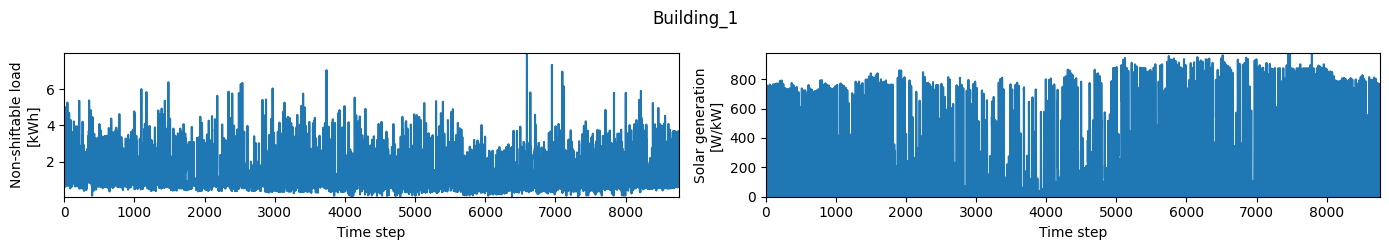

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 2.5))
x = building_data.index
y1 = building_data['non_shiftable_load']
y2 = building_data['solar_generation']
axs[0].plot(x, y1)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('Non-shiftable load\n[kWh]')
axs[1].plot(x, y2)
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Solar generation\n[W/kW]')
fig.suptitle(building_name)
plt.tight_layout()
plt.show()

Preview of the weather file

In [ ]:
filename = schema['buildings'][building_name]['weather']
filepath = os.path.join(root_directory, filename)
weather_data = pd.read_csv(filepath)
display(weather_data.head())

,outdoor_dry_bulb_temperature,outdoor_relative_humidity,diffuse_solar_irradiance,direct_solar_irradiance,outdoor_dry_bulb_temperature_predicted_6h,outdoor_dry_bulb_temperature_predicted_12h,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
0,20.0,84.0,0.0,0.0,18.3,22.8,20.0,81.0,68.0,81.0,25.0,964.0,0.0,100.0,815.0,0.0
1,20.1,79.0,0.0,0.0,19.4,22.8,19.4,79.0,71.0,87.0,201.0,966.0,0.0,444.0,747.0,0.0
2,19.7,78.0,0.0,0.0,21.1,22.2,19.4,73.0,73.0,87.0,420.0,683.0,0.0,592.0,291.0,0.0
3,19.3,78.0,0.0,0.0,22.2,22.8,19.4,71.0,71.0,90.0,554.0,522.0,0.0,491.0,153.0,0.0
4,18.9,78.0,0.0,0.0,21.7,22.2,18.9,73.0,71.0,90.0,778.0,444.0,0.0,734.0,174.0,0.0


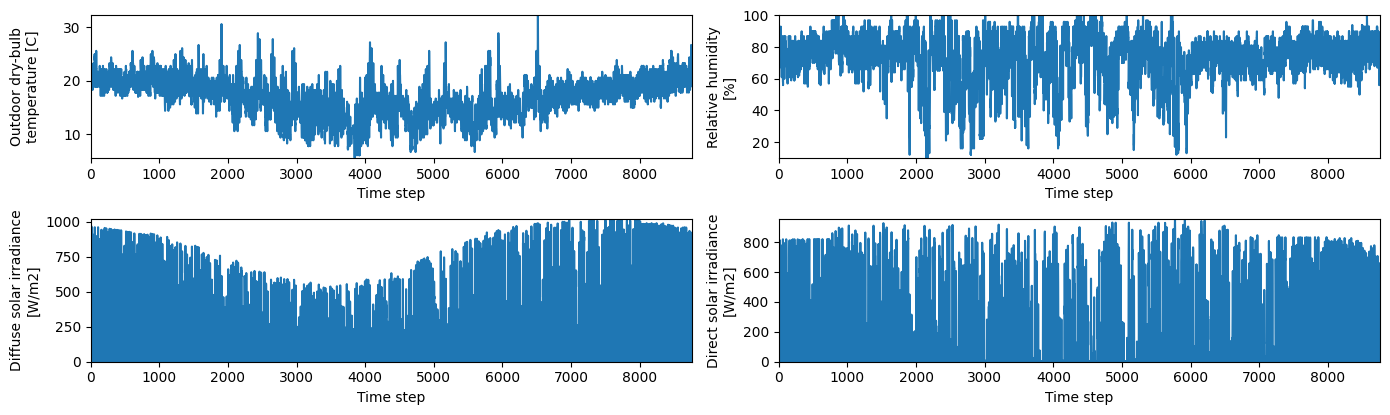

In [ ]:
columns = [
    'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity',
    'diffuse_solar_irradiance', 'direct_solar_irradiance'
]
titles = [
    'Outdoor dry-bulb\ntemperature [C]', 'Relative humidity\n[%]',
    'Diffuse solar irradiance\n[W/m2]', 'Direct solar irradiance\n[W/m2]'
]
fig, axs = plt.subplots(2, 2, figsize=(14, 4.25))
x = weather_data.index

for ax, c, t in zip(fig.axes, columns, titles):
    y = weather_data[c]
    ax.plot(x, y)
    ax.set_xlabel('Time step')
    ax.set_ylabel(t)

fig.align_ylabels()
plt.tight_layout()
plt.show()

Preview of electricity price data


In [ ]:
filename = schema['buildings'][building_name]['pricing']
filepath = os.path.join(root_directory, filename)
pricing_data = pd.read_csv(filepath)
display(pricing_data.head())

,electricity_pricing,electricity_pricing_predicted_6h,electricity_pricing_predicted_12h,electricity_pricing_predicted_24h
0,0.22,0.22,0.22,0.22
1,0.22,0.22,0.22,0.22
2,0.22,0.22,0.22,0.22
3,0.22,0.22,0.22,0.22
4,0.22,0.22,0.54,0.22


# Data preprocessing

Selection of the subset of the buildings to use -> improve the speed of the training and results.


## Building selection function
Selection of the building function: the function will allow to choose between the buildings that are available in the dataset. This will only select a few in order to improve the speed of the
training and evaluation of the model. Building 12 and Building 15 will be excluded by default.

In [ ]:
def select_buildings(
dataset_name: str, count: int, seed: int, buildings_to_exclude: list[str] = None,
) -> list[str]:
    """ Randoms elect buildings from Citylearn dataset.

    Parameters
    ----------
    dataset_name = str
        CityLearn dataset to query buildings from.
    count: int
        Number of buildings to set as active in schema.
    seed: int
        Seed for pseudo-random number generator
    building_to_exclude: list[str]
        List of buildings to exclude from selection pool

    Returns
    -------
    buildings: list[str]
    """

    assert 1 <= count <= 15, 'count must be between 1 and 15'

    # set random seed
    np.random.seed(seed)

    # get all bulding names
    schema = DataSet.get_schema(dataset_name)
    buildings = list(schema['buildings'].keys())

    # remove buildings 12 and 15 as they have peculiarities in thei data
    # that are no relevant for this application
    buildings_to_exclude = [] if buildings_to_exclude is None \
        else [b for b in buildings_to_exclude]
    buildings_to_exclude += ['Building_12', 'Building_15']

    for b in buildings_to_exclude:
        if b in buildings:
            buildings.remove(b)

    # randomly select specified number of buildings
    buildings = np.random.choice(buildings, count, replace=False)

    return buildings.tolist()

## Simulation period selection function
The following function will allow to select the simualtion period of the algorithm

In [ ]:
def select_simulation_period(
    dataset_name: str, count: int, seed: int,
    simulation_periods_to_exclude: list[tuple[int, int]] = None
) -> tuple[int, int]:
    """Randomly select environment simulation start and end time steps
    that cover a specified number of days.

    Parameters
    ----------
    dataset_name: str
        CityLearn dataset to query buildings from.
    count: int
        Number of simulation days.
    seed: int
        Seed for pseudo-random number generator.
    simulation_periods_to_exclude: list[tuple[int, int]]
        List of simulation periods to exclude from selection pool.

    Returns
    -------
    simulation_start_time_step: int
        The first time step in schema time series files to
        be read when constructing the environment.
    simulation_end_time_step: int
        The last time step in schema time series files to
        be read when constructing the environment.
    """

    assert 1 <= count <= 365, 'count must be between 1 and 365.'

    # set random seed
    np.random.seed(seed)

    # use any of the files to determine the total
    # number of available time steps
    schema = DataSet.get_schema(dataset_name)
    filename = schema['buildings'][building_name]['carbon_intensity']
    filepath = os.path.join(root_directory, filename)
    time_steps = pd.read_csv(filepath).shape[0]

    # set candidate simulation start time steps
    # spaced by the number of specified days
    simulation_start_time_step_list = np.arange(0, time_steps, 24*count)

    # exclude period if needed
    if simulation_periods_to_exclude is not None:
        simulation_start_time_step_list_to_exclude = \
            [s for s, e in simulation_periods_to_exclude]
        simulation_start_time_step_list = np.setdiff1d(
            simulation_start_time_step_list,
            simulation_start_time_step_list_to_exclude
        )

    else:
        pass

    # randomly select a simulation start time step
    simulation_start_time_step = np.random.choice(
        simulation_start_time_step_list, size=1
    )[0]
    simulation_end_time_step = simulation_start_time_step + 24*count - 1

    # Split for testing and training
    # 70% testing
    # 30% training
    training_days = int(count*0.7)
    testing_days = int(count*0.3)

    training_time_steps = training_days*24
    testing_time_steps = testing_days*24

    training_start_time_step = simulation_start_time_step
    training_end_time_step   = simulation_start_time_step + training_time_steps -1

    testing_start_time_step = training_end_time_step + 1
    testing_end_time_step   = testing_start_time_step + testing_time_steps -1



    return simulation_start_time_step, simulation_end_time_step, training_start_time_step, training_end_time_step, testing_start_time_step, testing_end_time_step



In [ ]:
'''
count = 30

training_days = int(count*0.7)
testing_days = int(count*0.3)

training_time_steps = training_days*24
testing_time_steps = testing_days*24

training_start_time_step = SIMULATION_START_TIME_STEP
training_end_time_step   = SIMULATION_START_TIME_STEP + training_time_steps - 1

testing_start_time_step = training_end_time_step + 1
testing_end_time_step   = testing_start_time_step + testing_time_steps -1

print('Training start time step:', training_start_time_step)
print('Training end time step:', training_end_time_step)
print('Testing start time step:', testing_start_time_step)
print('Testing end time step:', testing_end_time_step)

print(SIMULATION_START_TIME_STEP, SIMULATION_END_TIME_STEP)
print("Training days: ",(training_end_time_step - training_start_time_step+1)/24)
print("Testing days:  ",(testing_end_time_step - testing_start_time_step)/24)
'''

'\ncount = 30\n\ntraining_days = int(count*0.7)\ntesting_days = int(count*0.3)\n\ntraining_time_steps = training_days*24\ntesting_time_steps = testing_days*24\n\ntraining_start_time_step = SIMULATION_START_TIME_STEP\ntraining_end_time_step   = SIMULATION_START_TIME_STEP + training_time_steps - 1\n\ntesting_start_time_step = training_end_time_step + 1\ntesting_end_time_step   = testing_start_time_step + testing_time_steps -1\n\nprint(\'Training start time step:\', training_start_time_step)\nprint(\'Training end time step:\', training_end_time_step)\nprint(\'Testing start time step:\', testing_start_time_step)\nprint(\'Testing end time step:\', testing_end_time_step)\n\nprint(SIMULATION_START_TIME_STEP, SIMULATION_END_TIME_STEP)\nprint("Training days: ",(training_end_time_step - training_start_time_step+1)/24)\nprint("Testing days:  ",(testing_end_time_step - testing_start_time_step)/24)\n'

## Random seed for reproductibility

In [ ]:
RANDOM_SEED=42

## Select Buildings, Time Periods and Observations to use in the simulations

In [ ]:
BUILDING_COUNT = 3
BUILDINGS = select_buildings(
    DATASET_NAME,
    BUILDING_COUNT,
    RANDOM_SEED,
)
print('Selected building:', BUILDINGS)

DAY_COUNT = 30
SIMULATION_START_TIME_STEP, SIMULATION_END_TIME_STEP,\
TRAINING_START_TIME_STEP, TRAINING_END_TIME_STEP,\
TESTING_START_TIME_STEP, TESTING_END_TIME_STEP = select_simulation_period(
    DATASET_NAME,
    DAY_COUNT,
    RANDOM_SEED
)

EPISODE_TIME_STEPS = 24; # I choose to run it over 1 day for multiple periods

print(
    f'Selected {DAY_COUNT}-day simulation period:',
    (SIMULATION_START_TIME_STEP, SIMULATION_END_TIME_STEP)
)
print(
    f'Selected {DAY_COUNT*0.7}-day training period:',
    (TRAINING_START_TIME_STEP, TRAINING_END_TIME_STEP)
)
print(f'Selected {DAY_COUNT*0.3}-day testing period:',
    (TESTING_START_TIME_STEP, TESTING_END_TIME_STEP)
)

ACTIVE_OBSERVATIONS = ['hour']


# The control will be centralized: one agent will control al the buildings.
CENTRAL_AGENT = True

Selected building: ['Building_2', 'Building_5', 'Building_3']
Selected 30-day simulation period: (np.int64(4320), np.int64(5039))
Selected 21.0-day training period: (np.int64(4320), np.int64(4823))
Selected 9.0-day testing period: (np.int64(4824), np.int64(5039))


In [ ]:
(TESTING_END_TIME_STEP-TESTING_START_TIME_STEP+1)/24

np.float64(9.0)

In [ ]:
# Environment initialization
env = CityLearnEnv(
    DATASET_NAME,
    central_agent = CENTRAL_AGENT,
    buildings = BUILDINGS,
    simulation_start_time_step = TRAINING_START_TIME_STEP,
    simulation_end_time_step = TRAINING_END_TIME_STEP,
    episode_time_steps = EPISODE_TIME_STEPS,
)

print('Current time step:', env.time_step)
print('environment number of time steps:', env.time_steps)
print('environment uses central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))

# Now let's calculate also the number of the episodes

first_valid_start = TRAINING_START_TIME_STEP
last_valid_start = TRAINING_END_TIME_STEP - EPISODE_TIME_STEPS

print('Simulation_start_time_step', TRAINING_START_TIME_STEP)
print('Simulation_end_time_step', TRAINING_END_TIME_STEP)
print('Last episode starts:',last_valid_start)

episodes = (last_valid_start - first_valid_start +1)/EPISODE_TIME_STEPS + 1
print('Episodes available:',episodes)

total_training_time_steps = TRAINING_END_TIME_STEP - TRAINING_START_TIME_STEP + 1
print('Total time steps:', total_training_time_steps)

episodes*EPISODE_TIME_STEPS

Current time step: 0
environment number of time steps: 24
environment uses central agent: True
Number of buildings: 3
Simulation_start_time_step 4320
Simulation_end_time_step 4823
Last episode starts: 4799
Episodes available: 21.0
Total time steps: 504


np.float64(504.0)

In [ ]:
observations, _ = env.reset()
obs = observations[0]
obs_names = env.observation_names[0]

print(len(obs), len(obs_names))
obs_dict = dict(zip(obs_names, obs))

obs_dict,

36 36


({'month': np.int32(1),
  'day_type': np.int32(5),
  'hour': np.int32(24),
  'outdoor_dry_bulb_temperature': np.float32(12.8),
  'outdoor_dry_bulb_temperature_predicted_6h': np.float32(14.4),
  'outdoor_dry_bulb_temperature_predicted_12h': np.float32(17.2),
  'outdoor_dry_bulb_temperature_predicted_24h': np.float32(12.2),
  'outdoor_relative_humidity': np.float32(96.0),
  'outdoor_relative_humidity_predicted_6h': np.float32(96.0),
  'outdoor_relative_humidity_predicted_12h': np.float32(84.0),
  'outdoor_relative_humidity_predicted_24h': np.float32(100.0),
  'diffuse_solar_irradiance': np.float32(0.0),
  'diffuse_solar_irradiance_predicted_6h': np.float32(0.0),
  'diffuse_solar_irradiance_predicted_12h': np.float32(285.0),
  'diffuse_solar_irradiance_predicted_24h': np.float32(0.0),
  'direct_solar_irradiance': np.float32(0.0),
  'direct_solar_irradiance_predicted_6h': np.float32(0.0),
  'direct_solar_irradiance_predicted_12h': np.float32(6.0),
  'direct_solar_irradiance_predicted_24h':

In [ ]:
print(len(obs_dict))

28


## Get KPIs for evaluations
We will take into account 5 KPIs that are to be minimized:
1. electricity cost;
2. carbon emissions;
3. average daily peak;
4. ramping;
5. 1-load factor;

3 and 5 are District level KPIs


### Convenience functions to Display Simulation Results

#### Plot Building KPI

In [ ]:
def get_kpis(env: CityLearnEnv) -> pd.DataFrame:
    """Returns evaluation KPIs.

    Electricity cost and carbon emissions KPIs are provided
    at the building-level and average district-level. Average daily peak,
    ramping and (1 - load factor) KPIs are provided at the district level.

    Parameters
    ----------
    env: CityLearnEnv
        CityLearn environment instance.

    Returns
    -------
    kpis: pd.DataFrame
        KPI table.
    """

    kpis = env.unwrapped.evaluate()

    # names of KPIs to retrieve from evaluate function
    kpi_names = {
        'cost_total': 'Cost',
        'carbon_emissions_total': 'Emissions',
        'daily_peak_average': 'Avg. daily peak',
        'ramping_average': 'Ramping',
        'monthly_one_minus_load_factor_average': '1 - load factor'
    }
    kpis = kpis[
        (kpis['cost_function'].isin(kpi_names))
    ].dropna()
    kpis['cost_function'] = kpis['cost_function'].map(lambda x: kpi_names[x])

    # round up the values to 2 decimal places for readability
    kpis['value'] = kpis['value'].round(2)

    # rename the column that defines the KPIs
    kpis = kpis.rename(columns={'cost_function': 'kpi'})

    return kpis

In [ ]:
def plot_building_kpis(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost and carbon emissions
    at the building-level for different control agents in bar charts.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='building'].copy()
        kpis['building_id'] = kpis['name'].str.split('_', expand=True)[1]
        kpis['building_id'] = kpis['building_id'].astype(int).astype(str)
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    kpi_names= kpis['kpi'].unique()
    column_count_limit = 3
    row_count = math.ceil(len(kpi_names)/column_count_limit)
    column_count = min(column_count_limit, len(kpi_names))
    building_count = len(kpis['name'].unique())
    env_count = len(envs)
    figsize = (3.0*column_count, 0.3*env_count*building_count*row_count)
    fig, _ = plt.subplots(
        row_count, column_count, figsize=figsize, sharey=True
    )

    for i, (ax, (k, k_data)) in enumerate(zip(fig.axes, kpis.groupby('kpi'))):
        sns.barplot(x='value', y='name', data=k_data, hue='env_id', ax=ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(k)

        for j, _ in enumerate(envs):
            ax.bar_label(ax.containers[j], fmt='%.2f')

        if i == len(kpi_names) - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

    return fig

#### Plot district KPI

In [ ]:
def plot_district_kpis(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost, carbon emissions,
    average daily peak, ramping and (1 - load factor) at the
    district-level for different control agents in a bar chart.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='district'].copy()
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    row_count = 1
    column_count = 1
    env_count = len(envs)
    kpi_count = len(kpis['kpi'].unique())
    figsize = (6.0*column_count, 0.225*env_count*kpi_count*row_count)
    fig, ax = plt.subplots(row_count, column_count, figsize=figsize)
    sns.barplot(x='value', y='kpi', data=kpis, hue='env_id', ax=ax)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    for j, _ in enumerate(envs):
        ax.bar_label(ax.containers[j], fmt='%.2f')

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)
    plt.tight_layout()

    return fig

#### Plot building load profile

In [ ]:
def plot_building_load_profiles(
    envs: dict[str, CityLearnEnv], daily_average: bool = None
) -> plt.Figure:
    """Plots building-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    daily_average: bool, default: False
        Whether to plot the daily average load profile.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    daily_average = False if daily_average is None else daily_average
    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.75*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            y = v.unwrapped.buildings[i].net_electricity_consumption
            y = np.reshape(y, (-1, 24)).mean(axis=0) if daily_average else y
            x = range(len(y))
            ax.plot(x, y, label=k)

        ax.set_title(v.unwrapped.buildings[i].name)
        ax.set_ylabel('kWh')

        if daily_average:
            ax.set_xlabel('Hour')
            ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

        else:
            ax.set_xlabel('Time step')
            ax.xaxis.set_major_locator(ticker.MultipleLocator(24*7))

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig

#### Plot District Load Profile

In [ ]:
def plot_district_load_profiles(
    envs: dict[str, CityLearnEnv], daily_average: bool = None
) -> plt.Figure:
    """Plots district-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    daily_average: bool, default: False
        Whether to plot the daily average load profile.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    daily_average = False if daily_average is None else daily_average
    figsize = (5.0, 1.5)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    for k, v in envs.items():
        y = v.unwrapped.net_electricity_consumption
        y = np.reshape(y, (-1, 24)).mean(axis=0) if daily_average else y
        x = range(len(y))
        ax.plot(x, y, label=k)

    ax.set_ylabel('kWh')

    if daily_average:
        ax.set_xlabel('Hour')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

    else:
        ax.set_xlabel('Time step')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24*7))

    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

    plt.tight_layout()
    return fig

#### Plot SOC profiles

In [ ]:
def plot_battery_soc_profiles(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots building-level battery SoC profiles fro different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.75*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            y = np.array(v.unwrapped.buildings[i].electrical_storage.soc)
            x = range(len(y))
            ax.plot(x, y, label=k)

        ax.set_title(v.unwrapped.buildings[i].name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('SoC')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24*7))
        ax.set_ylim(0.0, 1.0)

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig



#### Plot Simulation Summary


In [ ]:
def plot_simulation_summary(envs: dict[str, CityLearnEnv]):
    """Plots KPIs, load and battery SoC profiles for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    """

    print('#'*8 + ' BUILDING-LEVEL ' + '#'*8)
    print('Building-level KPIs:')
    _ = plot_building_kpis(envs)
    plt.show()

    print('Building-level simulation period load profiles:')
    _ = plot_building_load_profiles(envs)
    plt.show()

    print('Building-level daily-average load profiles:')
    _ = plot_building_load_profiles(envs, daily_average=True)
    plt.show()

    print('Battery SoC profiles:')
    _ = plot_battery_soc_profiles(envs)
    plt.show()

    print('#'*8 + ' DISTRICT-LEVEL ' + '#'*8)
    print('District-level KPIs:')
    _ = plot_district_kpis(envs)
    plt.show()

    print('District-level simulation period load profiles:')
    _ = plot_district_load_profiles(envs)
    plt.show()

    print('District-level daily-average load profiles:')
    _ = plot_district_load_profiles(envs, daily_average=True)
    plt.show()

#### Plot Actions

In [ ]:
def plot_actions(actions_list: list[list[float]], building_names: list[str], title: str) -> plt.Figure:
    """Plots action time series for different buildings

    Parameters
    ----------
    actions_list: list[list[float]]
        List of actions where each element with index, i,
        in list is a list of the actions for different buildings
        taken at time step i.
    building_names: list[str]:
        List of build names that map to the action lists.
    title: str
        Plot axes title

    Returns
    -------
    fig: plt.Figure
        Figure with plotted axes

    """

    fig, ax = plt.subplots(1, 1, figsize=(6, 1))
    plot_data = pd.DataFrame(actions_list, columns=building_names)
    x = list(range(plot_data.shape[0]))

    for c in plot_data.columns:
        y = plot_data[c].tolist()
        ax.plot(x, y, label=c)

    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
    ax.set_xlabel('Time step')
    ax.set_ylabel(r'$\frac{kWh}{kWh_{capacity}}$')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24*7))
    ax.set_title(title)

    return fig

#### Plot rewards

In [ ]:
def plot_rewards(ax: plt.Axes, rewards: list[float], title: str) -> plt.Axes:
    """Plots rewards over training episodes.

    Parameters
    ----------
    rewards: list[float]
        List of reward sum per episode.
    title: str
        Plot axes title

    Returns
    -------
    ax: plt.Axes
        Plotted axes
    """

    ax.plot(rewards)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title(title)

    return ax

# 1. Baseline Simulation

In [ ]:
baseline_env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=TESTING_START_TIME_STEP,
    simulation_end_time_step=TESTING_END_TIME_STEP,
)


In [ ]:
baseline_model = BaselineAgent(baseline_env)


/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [ ]:
print(env.reset())
print(baseline_env.reset())

([[np.int32(1), np.int32(6), np.int32(24), np.float32(12.2), np.float32(11.1), np.float32(17.8), np.float32(12.8), np.float32(100.0), np.float32(93.0), np.float32(81.0), np.float32(96.0), np.float32(0.0), np.float32(0.0), np.float32(550.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(627.0), np.float32(0.0), np.float32(0.13305952), np.float32(0.8769583), np.float32(0.0), np.float32(0.0), np.float32(0.8769583), np.float32(0.21), np.float32(0.21), np.float32(0.21), np.float32(0.21), np.float32(0.48063335), np.float32(0.0), np.float32(0.0), np.float32(0.48063335), np.float32(1.530425), np.float32(0.0), np.float32(0.0), np.float32(1.530425)]], {})
([[np.int32(24)]], {})


In [ ]:
# always start by reseting the environment
observations, _ = baseline_env.reset()
step_count = 0
# step through the environment until terminal
# state is reached i.e., the control episode ends
while not baseline_env.terminated:   # usare gli step qui e non "terminated"
    # select actions from the model
    actions = baseline_model.predict(observations)
    step_count = step_count + 1
    if step_count%20 == 0:
      print(actions)
      print(observations)

    # apply selected actions to the environment
    observations, _, _, _, _ = baseline_env.step(actions)

# Note to self, the episode_count = episodes_time_steps - 1.
# The env run the test the number of timesteps set in the env.
# If you do not set the episode_timesteps, it will be automatically set to:
# SIMULATION_START_TIME_STEPS - SIMULATION_END_TIME_STEPS + 1
step_count

[[]]
[[np.int32(19)]]
[[]]
[[np.int32(15)]]
[[]]
[[np.int32(11)]]
[[]]
[[np.int32(7)]]
[[]]
[[np.int32(3)]]
[[]]
[[np.int32(23)]]
[[]]
[[np.int32(19)]]
[[]]
[[np.int32(15)]]
[[]]
[[np.int32(11)]]
[[]]
[[np.int32(7)]]


215

######## BUILDING-LEVEL ########
Building-level KPIs:


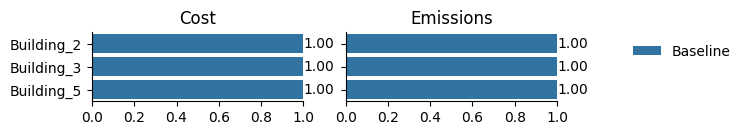

Building-level simulation period load profiles:


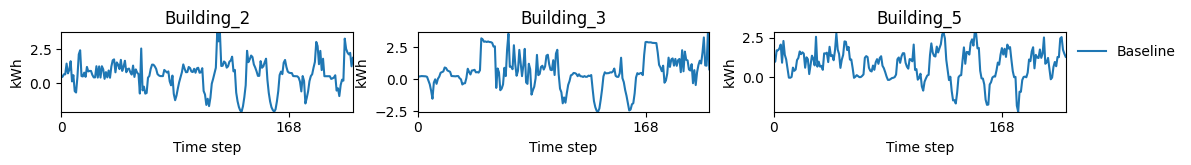

Building-level daily-average load profiles:


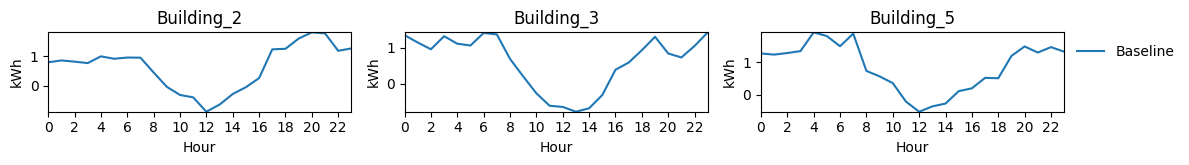

Battery SoC profiles:


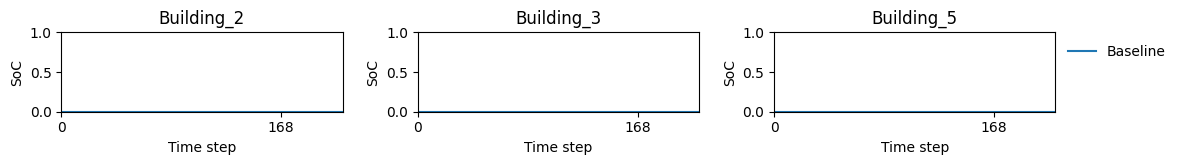

######## DISTRICT-LEVEL ########
District-level KPIs:


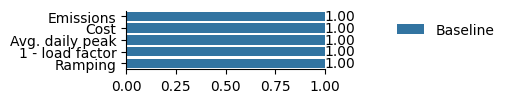

District-level simulation period load profiles:


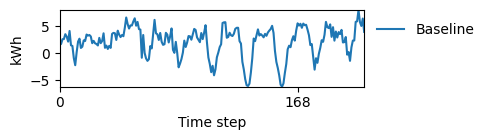

District-level daily-average load profiles:


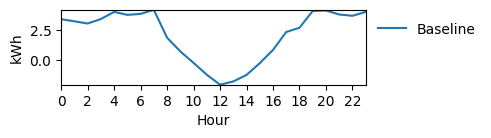

In [ ]:
plot_simulation_summary({
    'Baseline': baseline_env,
})

In [ ]:
observations = baseline_env.reset()
observations

([[np.int32(24)]], {})

# Custom reward

## Base case

In [ ]:
class CustomReward(RewardFunction):
    def __init__(self, env_metadata: dict[str, Any]):
        r""" Initialize CustomReward

        Parameters
        ------
        env_metadata: dic[str, Any]:
        General static information about the environment.
        """
        super().__init__(env_metadata)

    def calculate(
        self, observations: list[dict[str,int | float]]
    ) -> list[float]:
        r"""Returns reward for most recent action.

        The reward is designed to minimize electricity cost.
        It is calculated for each building, i and summed to provide the agent
        with a reward that is representative of all n buildings.
        It encourages net-zero energy use by penalizing grid load satisfaction
        when there is energy in the battery as well as penalizing
        net export when the battery is not fully charged through the penalty
        term. There is neither penalty nor reward when the battery
        is fully charged during net export to the grid. Whereas, when the
        battery is charged to capacity and there is net import from the
        grid the penalty is maximized.

        Parameters
        ----------
        observations: list[dict[str, int | float]]
            List of all building observations at current
            :py:attr:`citylearn.citylearn.CityLearnEnv.time_step`
            that are got from calling
            :py:meth:`citylearn.building.Building.observations`.

        Returns
        -------
        reward: list[float]
            Reward for transition to current timestep.
        """

        reward_list = []

        for o, m in zip(observations, self.env_metadata['buildings']):
            cost = o['net_electricity_consumption']*o['electricity_pricing']
            battery_soc = o['electrical_storage_soc']
            penalty = -(1.0 + np.sign(cost)*battery_soc)
            reward = penalty*abs(cost)
            reward_list.append(reward)

        reward = [sum(reward_list)]

        return reward

## 1st attempt


In [ ]:

class AdaptiveWeightReward(RewardFunction):
    def __init__(self, env, epsilon=1e-6, log_interval=100):
        super().__init__(env)
        self.epsilon = epsilon
        self.log_interval = log_interval
        self.step_count = 0

        self.prev_district_load = 0.0
        self.district_load_hist = []

        # Histories for adaptive weights
        self.cost_hist = []
        self.carbon_hist = []
        self.peak_hist = []
        self.ramp_hist = []
        self.lf_hist = []

        # Initialize alphas
        self.alpha_c = 1.0
        self.alpha_co = 1.0
        self.alpha_p = 1.0
        self.alpha_r = 1.0
        self.alpha_lf = 1.0

    def reward(self, reward):
        obs = self.env.observe()

        # Extract variables
        prices = [o["electricity_pricing"] for o in obs]
        carbon = [o["carbon_intensity"] for o in obs]
        net_loads = [o["net_electricity_consumption"] for o in obs]

        district_load = np.sum(net_loads)

        # Cost contribution
        c_h = np.sum([max(0, net_loads[i]) * prices[i] for i in range(len(net_loads))])

        # Carbon contribution
        co_h = np.sum([max(0, net_loads[i]) * carbon[i] for i in range(len(net_loads))])

        # Peak proxy
        p_h = max(0, district_load)

        # Ramping
        r_h = abs(district_load - self.prev_district_load)

        # Update state for next step
        self.prev_district_load = district_load

        # Load factor proxy (variance from mean)
        self.district_load_hist.append(district_load)
        if len(self.district_load_hist) > 24:
            self.district_load_hist.pop(0)
        mean_load = np.mean(self.district_load_hist) if self.district_load_hist else district_load
        lf_h = abs(district_load - mean_load) / (mean_load + self.epsilon)

        # Store histories
        self.cost_hist.append(c_h)
        self.carbon_hist.append(co_h)
        self.peak_hist.append(p_h)
        self.ramp_hist.append(r_h)
        self.lf_hist.append(lf_h)

        # Update adaptive weights (inverse of running mean)
        self.alpha_c = 1.0 / (np.mean(self.cost_hist[-100:]) + self.epsilon)
        self.alpha_co = 1.0 / (np.mean(self.carbon_hist[-100:]) + self.epsilon)
        self.alpha_p = 1.0 / (np.mean(self.peak_hist[-100:]) + self.epsilon)
        self.alpha_r = 1.0 / (np.mean(self.ramp_hist[-100:]) + self.epsilon)
        self.alpha_lf = 1.0 / (np.mean(self.lf_hist[-100:]) + self.epsilon)

        # Log adaptive weights every log_interval steps
        self.step_count += 1
        if self.step_count % self.log_interval == 0:
            print(f"Step {self.step_count}: alphas -> cost={self.alpha_c:.4f}, carbon={self.alpha_co:.4f}, "
                  f"peak={self.alpha_p:.4f}, ramp={self.alpha_r:.4f}, load_factor={self.alpha_lf:.4f}")

        # Normalize values relative to running mean
        norm_c = c_h / (np.mean([c_h, 1.0]) + self.epsilon)
        norm_co = co_h / (np.mean([co_h, 1.0]) + self.epsilon)
        norm_p = p_h / (np.mean([p_h, 1.0]) + self.epsilon)
        norm_r = r_h / (np.mean([r_h, 1.0]) + self.epsilon)
        norm_lf = lf_h

        # Weighted negative sum with adaptive weights
        custom_reward = - (
            self.alpha_c * norm_c +
            self.alpha_co * norm_co +
            self.alpha_p * norm_p +
            self.alpha_r * norm_r +
            self.alpha_lf * norm_lf
        )

        return custom_reward


# 2. SAC Simulation

In [ ]:
# Example of split episodes.

SIMULATION_START_TIME_STEP
SIMULATION_END_TIME_STEP


# Example list with 720 items
data = list(range(SIMULATION_START_TIME_STEP, SIMULATION_END_TIME_STEP+1))  # Replace with your actual data

# Number of sublists
num_sublists = 30

# Calculate chunk size
chunk_size = len(data) // num_sublists  # 24 in this case

# Split into sublists
result = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]

print(f"Total sublists: {len(result)}")
print(result[0])  # First sublist
print(result[-1]) # Last sublist
print(result)

Total sublists: 30
[4320, 4321, 4322, 4323, 4324, 4325, 4326, 4327, 4328, 4329, 4330, 4331, 4332, 4333, 4334, 4335, 4336, 4337, 4338, 4339, 4340, 4341, 4342, 4343]
[5016, 5017, 5018, 5019, 5020, 5021, 5022, 5023, 5024, 5025, 5026, 5027, 5028, 5029, 5030, 5031, 5032, 5033, 5034, 5035, 5036, 5037, 5038, 5039]
[[4320, 4321, 4322, 4323, 4324, 4325, 4326, 4327, 4328, 4329, 4330, 4331, 4332, 4333, 4334, 4335, 4336, 4337, 4338, 4339, 4340, 4341, 4342, 4343], [4344, 4345, 4346, 4347, 4348, 4349, 4350, 4351, 4352, 4353, 4354, 4355, 4356, 4357, 4358, 4359, 4360, 4361, 4362, 4363, 4364, 4365, 4366, 4367], [4368, 4369, 4370, 4371, 4372, 4373, 4374, 4375, 4376, 4377, 4378, 4379, 4380, 4381, 4382, 4383, 4384, 4385, 4386, 4387, 4388, 4389, 4390, 4391], [4392, 4393, 4394, 4395, 4396, 4397, 4398, 4399, 4400, 4401, 4402, 4403, 4404, 4405, 4406, 4407, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415], [4416, 4417, 4418, 4419, 4420, 4421, 4422, 4423, 4424, 4425, 4426, 4427, 4428, 4429, 4430, 4431, 4432, 443

In [ ]:
sac_env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=TRAINING_START_TIME_STEP,
    simulation_end_time_step=TRAINING_END_TIME_STEP,
    reward_function=CustomReward,
    episode_time_steps=EPISODE_TIME_STEPS,
)

In [ ]:
# 1st Wrap to categorize all the observations in the interval [0,1]
sac_env = NormalizedObservationWrapper(sac_env)

In [ ]:
# 2nd Wrap to b eable to use the pre-installed algorithms within StableBaselines3
sac_env = StableBaselines3Wrapper(sac_env)

In [ ]:
print(sac_env.reset())

(array([1. , 0.5], dtype=float32), {})


In [ ]:
# Inizialize the SAC MODEL
sac_model = SAC(policy='MlpPolicy', env=sac_env, seed=RANDOM_SEED)

In [ ]:
# Second model to compare training
sac_model_2 = SAC(policy='MlpPolicy', env=sac_env, seed=RANDOM_SEED)

In [ ]:
sac_episodes = int(episodes)
sac_episode_timesteps = sac_env.unwrapped.time_steps
sac_total_timesteps = sac_episodes*sac_episode_timesteps

print(sac_episodes)
print(sac_episode_timesteps)
print(sac_total_timesteps)

# Ref without setting episode_time_steps = EPISODE_TIME_STEPS in env
# sac episodes:           30
# sac episodes timesteps: 720
# sac total timesteps:    21600
print(EPISODE_TIME_STEPS)

21
24
504
24


### Consideration for the training on SB3.
There are two ways available for training with SB3.

1. `model.learn(total_timesteps = 30*24, reset_num_timesteps = False )` - In this case the total_timesteps are 720. If in the createiion of the citylearn environment the episode_timesteps are set to 24 the training will be done over the 30 episodes. The model won't run over the same 24 chunks as long as `reset_num_timesteps = False`.

2. `for _ in range(30):
        model.learn(total_timesteps=24, reset_num_timesteps=False)`

Is the same as before, It just feel more manual and gives controlo to insert logic between episodes.


**Some considerations**

a. Option 1 is almost always better because everytime `model.learn()` is called DB3 has to:
1. rebuild some training buffers;
2. reset parts of the rollout manager;
3. Re-run certain checks and initializations.

So with the loop this has to happen 30x more often wasting time.

b. SB3 algos store recent experiences in buffers (replay buffer for SAC, rollout buffer for PPO) across episodes.
In the 1st option the replay buffers fill coninously for 720 steps, giving the agent a richer, more varied pool of experiences to learn from in each gradient update.

In the 2nd option the buffer is only filled in tiny 24-steps burts, and in many cases, updates start from a much smaller set of experiences, which hurts tability

c. Better gradient updates.
For off-policy SAC algos like SA:
- Replay buffer can sample from * multiple episode at once* if it is kept alive.
- Calling `.learn()` in small chuncks still works (because `reset_num_timesteps = False`), but you're feeding the buffer in small trickles insted of a steady stream - less efficient for training.

d. Logging and learning rate schedules
SB3'S learning rate schedules and progrss meteres use the internal timestep counter.
- Option 1, scheduler sees smooth 0 --> 720 progression.
- Option 2, it still counts correctly if `reset_num_timesteps=Flase`, but logging and callbacks can trigger too frequently adding noise.





### Callback for monitor the training
Now in this section we want to monitor the training in the two different approaches.



In [ ]:
class AverageRewardCallback(BaseCallback):
    def __init__(self, verbose=1):
        super().__init__(verbose)
        self.episode_rewards = []   # Stores total reward per episode
        self.current_reward = 0

    def _on_step(self) -> bool:
        # Accumulate rewards for the current episode
        self.current_reward += self.locals["rewards"][0]

        # When episode ends
        if self.locals["dones"][0]:
            self.episode_rewards.append(self.current_reward)
            avg_reward = np.mean(self.episode_rewards)
            if self.verbose > 0:
                print(f"Episode {len(self.episode_rewards)} | "
                      f"Reward: {self.current_reward:.2f} | "
                      f"Avg Reward: {avg_reward:.2f}")

            self.current_reward = 0  # reset for next episode

        return True

    def _on_training_end(self):
        if self.verbose > 0:
            print(f"\nTraining complete. Final Average Reward: {np.mean(self.episode_rewards):.2f}")

    def get_rewards(self):
        """Returns the list of episode rewards."""
        return self.episode_rewards

In [ ]:
### function to calculate the average reward per epoch
def average_epoch_reward(episode_rewards, epochs, episodes):
  average = []
  for ii in range(0, len(episode_rewards), episodes):
    chunk = episode_rewards[ii:ii+episodes]
    if chunk:
      average.append(sum(chunk)/len(chunk))
    else:
      average.append(0)
  return average


In [ ]:
callback_1 = AverageRewardCallback(verbose=0)
callback_2 = AverageRewardCallback(verbose=0)

### Training the Algorithm


In [ ]:
# How it was in the tutorial
# --- TRAIN THE MODEL ---
EPOCHS = 50
epochs = EPOCHS
sac_env.reset()

start_time = time.perf_counter()
for epoch in tqdm(range(epochs)):
  ###
  # Reset dopo ogni epoca, ma tieni anche quello senza reset per vedere la differenza.
  ###
  for ii in (range(int(sac_episodes))):
    sac_model.learn(
        total_timesteps=sac_episode_timesteps,
        reset_num_timesteps=False,
        callback=callback_1,
  )
elapsed_big = time.perf_counter() - start_time
print("Tutorial training time: ", elapsed_big)

100%|██████████| 50/50 [06:47<00:00,  8.15s/it]

Tutorial training time:  407.734786744


In [ ]:
execute=1
if execute==1:
  # Faster training
  sac_env.reset()

  start_time = time.perf_counter()
  sac_model_2.learn(
      total_timesteps=sac_total_timesteps*epochs,
      reset_num_timesteps = False,
      callback=callback_2,
      )
  elapsed_big = time.perf_counter() - start_time
  print("Faster Training Method: ", elapsed_big)
else:
    pass


Faster Training Method:  384.7790173269999


In [ ]:
print('First method:', epochs*sac_episodes*sac_episode_timesteps)
print('Second method: ',sac_total_timesteps*epochs)
sac_total_timesteps*epochs

First method: 25200
Second method:  25200


25200

## Evaluation of the algorithm
In SB3 there is nothing ' built-in' that will automatically make the model run for n episodes, a loop has to be strucutred to do that.

In citylearn the "data set" is cronological. Everytime `env.step()` is called without resettting, the model will go through the dataset only once. If you reset each time, you restart from the beginning of the defined episode.

The best approach for time and computing power purpose is to go for one episode over the entire data for evaluation. In the next cell `while not sac_env.unwrapped.terminated` will run over the entire dataset once. It will be termineted once it gest to the `simulation_end_timestep`.

Note: It is importat that you have to recreate the environment without the `episode_time_steps=24' otherwise it will run only for the first 24 samples and not over the entire dataset.


### Algo Evaluation

This is first model  1095
This is second model  1095
53
53


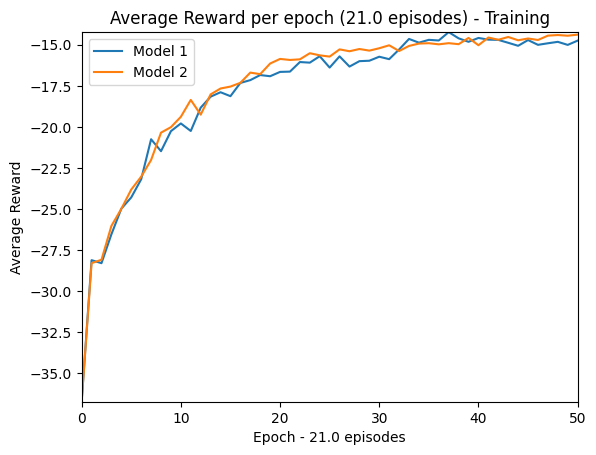

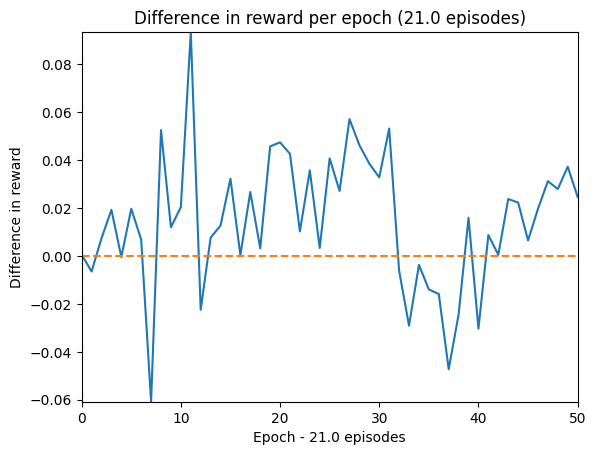

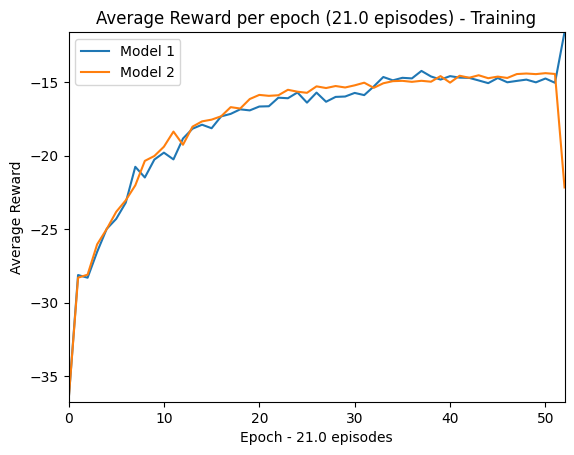

In [ ]:
average_epoch_reward_1 = average_epoch_reward(callback_1.episode_rewards, epochs, sac_episodes)
average_epoch_reward_2 = average_epoch_reward(callback_2.episode_rewards, epochs, sac_episodes)
print("This is first model ",len(callback_1.episode_rewards))
print("This is second model ", len(callback_2.episode_rewards))
print(len(average_epoch_reward_1))
print(len(average_epoch_reward_2))


plt.plot(average_epoch_reward_1[0:epochs+1])
plt.plot(average_epoch_reward_2[0:epochs+1])
plt.legend(["Model 1", "Model 2"])
plt.title(f"Average Reward per epoch ({episodes} episodes) - Training")
plt.xlabel(f"Epoch - {episodes} episodes")
plt.ylabel("Average Reward")
plt.show()

difference_in_reward = (abs(np.array(average_epoch_reward_1)) - abs(np.array(average_epoch_reward_2)))/abs(np.array(average_epoch_reward_1))
plt.plot(difference_in_reward[0:epochs+1])
plt.plot([0]*len(difference_in_reward[0:epochs+1]), linestyle = '--')
plt.title(f"Difference in reward per epoch ({episodes} episodes)")
plt.xlabel(f"Epoch - {episodes} episodes")
plt.ylabel("Difference in reward")
plt.show()


plt.plot(average_epoch_reward_1)
plt.plot(average_epoch_reward_2)
plt.legend(["Model 1", "Model 2"])
plt.title(f"Average Reward per epoch ({episodes} episodes) - Training")
plt.xlabel(f"Epoch - {episodes} episodes")
plt.ylabel("Average Reward")
plt.show()

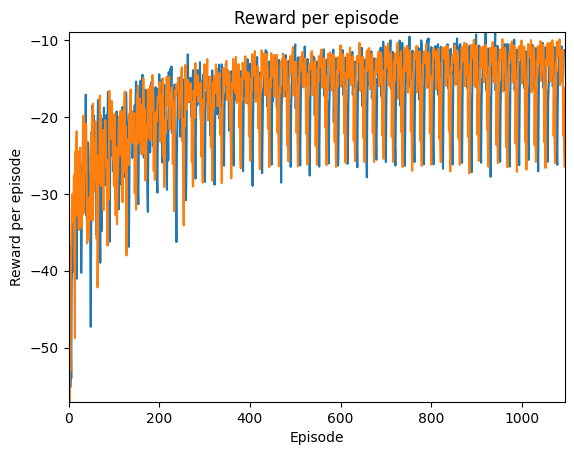

In [ ]:
plt.plot(callback_1.episode_rewards)
plt.plot(callback_2.episode_rewards)
plt.title("Reward per episode")
plt.xlabel("Episode")
plt.ylabel("Reward per episode")
plt.show()


In [ ]:
sac_env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=TESTING_START_TIME_STEP,
    simulation_end_time_step=TESTING_END_TIME_STEP,
    reward_function=CustomReward,
)
# 1st Wrap to categorize all the observations in the interval [0,1]
sac_env = NormalizedObservationWrapper(sac_env)
# 2nd Wrap to b eable to use the pre-installed algorithms within StableBaselines3
sac_env = StableBaselines3Wrapper(sac_env)


observations, _ = sac_env.reset()
print(observations)
sac_action_list = []
reward_list = []
counter_steps = 0
while not sac_env.unwrapped.terminated:
    actions, _ = sac_model.predict(observations,
                                   deterministic=True)
    observations, reward,_,_,_ = sac_env.step(actions)
    sac_action_list.append(actions)
    reward_list.append(reward)
    counter_steps = counter_steps + 1

    if counter_steps%50==0:
      print(actions)
      print(observations)

print(counter_steps)

[1.  0.5]
[-0.46840784 -0.3944254  -0.37183678]
[0.9330127 0.75     ]
[-0.40801215 -0.36069816 -0.38968053]
[0.75      0.9330127]
[-0.3409706  -0.1712845  -0.43773404]
[0.5 1. ]
[-0.16785169 -0.2276119  -0.257322  ]
[0.25      0.9330127]
215


In [ ]:
print(ACTIVE_OBSERVATIONS)

['hour']


In [ ]:
def moving_average(arr, window_size):
    return np.convolve(arr, np.ones(window_size)/window_size, mode='valid')

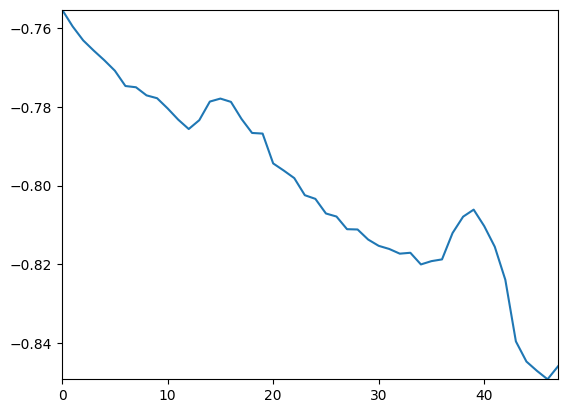

In [ ]:
moving_average_reward = moving_average(reward_list, window_size =24*7)
plt.plot(moving_average_reward)

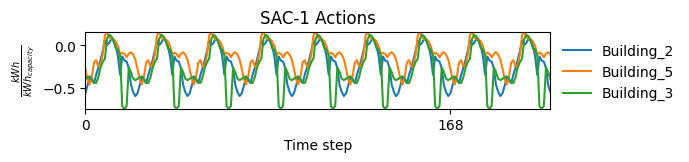

In [ ]:
# Let's plot the actions
fig = plot_actions(sac_action_list, BUILDINGS, 'SAC-1 Actions')


In [ ]:
plot_simulation_summary({
    'Baseline': baseline_env,
    'SAC': sac_env,
})

######## BUILDING-LEVEL ########
Building-level KPIs:


ZeroDivisionError: float division by zero

## Weight reward function

### Creation of the model

In [ ]:
# --- MODEL CREATION ---

sac_env_3_train = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=TRAINING_START_TIME_STEP,
    simulation_end_time_step=TRAINING_END_TIME_STEP,
    reward_function=AdaptiveWeightReward,
    episode_time_steps=EPISODE_TIME_STEPS,
)
sac_env_3_train = NormalizedObservationWrapper(sac_env_3_train)
sac_env_3_train = StableBaselines3Wrapper(sac_env_3_train)

sac_model_3 = SAC(policy='MlpPolicy', env=sac_env_3_train, seed=RANDOM_SEED)


### Traning

In [ ]:
# --- TRAINING ---
callback_3 = AverageRewardCallback(verbose=1)
sac_env_3_train.reset()

start_time = time.perf_counter()
for epoch in tqdm(range(epochs)):
  for ii in (range(int(sac_episodes))):
    sac_model_3.learn(
        total_timesteps=sac_episode_timesteps,
        reset_num_timesteps=False,
        callback=callback_3,
  )
elapsed_big = time.perf_counter() - start_time
print("Tutorial training time: ", elapsed_big)

  0%|          | 0/50 [00:00<?, ?it/s]

Episode 1 | Reward: -79.83 | Avg Reward: -79.83

Training complete. Final Average Reward: -79.83
Episode 2 | Reward: -72.59 | Avg Reward: -76.21

Training complete. Final Average Reward: -76.21
Episode 3 | Reward: -70.78 | Avg Reward: -74.40

Training complete. Final Average Reward: -74.40
Episode 4 | Reward: -66.93 | Avg Reward: -72.53

Training complete. Final Average Reward: -72.53
Episode 5 | Reward: -77.52 | Avg Reward: -73.53

Training complete. Final Average Reward: -73.53
Episode 6 | Reward: -109.69 | Avg Reward: -79.56

Training complete. Final Average Reward: -79.56
Episode 7 | Reward: -78.09 | Avg Reward: -79.35

Training complete. Final Average Reward: -79.35
Episode 8 | Reward: -82.12 | Avg Reward: -79.69

Training complete. Final Average Reward: -79.69
Episode 9 | Reward: -106.72 | Avg Reward: -82.70

Training complete. Final Average Reward: -82.70
Episode 10 | Reward: -77.80 | Avg Reward: -82.21

Training complete. Final Average Reward: -82.21
Episode 11 | Reward: -56.58

  2%|▏         | 1/50 [00:06<05:36,  6.86s/it]


Training complete. Final Average Reward: -65.45
Episode 22 | Reward: -44.39 | Avg Reward: -64.50

Training complete. Final Average Reward: -64.50
Episode 23 | Reward: -47.31 | Avg Reward: -63.75
Episode 24 | Reward: -36.78 | Avg Reward: -62.63

Training complete. Final Average Reward: -62.63
Episode 25 | Reward: -45.98 | Avg Reward: -61.96

Training complete. Final Average Reward: -61.96
Episode 26 | Reward: -42.36 | Avg Reward: -61.21

Training complete. Final Average Reward: -61.21
Episode 27 | Reward: -81.85 | Avg Reward: -61.97

Training complete. Final Average Reward: -61.97
Episode 28 | Reward: -57.88 | Avg Reward: -61.82

Training complete. Final Average Reward: -61.82
Episode 29 | Reward: -84.52 | Avg Reward: -62.61

Training complete. Final Average Reward: -62.61
Episode 30 | Reward: -103.45 | Avg Reward: -63.97

Training complete. Final Average Reward: -63.97
Episode 31 | Reward: -68.37 | Avg Reward: -64.11

Training complete. Final Average Reward: -64.11
Episode 32 | Reward

  4%|▍         | 2/50 [00:14<05:58,  7.47s/it]


Training complete. Final Average Reward: -57.97
Episode 44 | Reward: -41.78 | Avg Reward: -57.60

Training complete. Final Average Reward: -57.60
Episode 45 | Reward: -37.05 | Avg Reward: -57.15

Training complete. Final Average Reward: -57.15
Episode 46 | Reward: -40.95 | Avg Reward: -56.79

Training complete. Final Average Reward: -56.79
Episode 47 | Reward: -39.79 | Avg Reward: -56.43
Episode 48 | Reward: -77.99 | Avg Reward: -56.88

Training complete. Final Average Reward: -56.88
Episode 49 | Reward: -62.40 | Avg Reward: -56.99

Training complete. Final Average Reward: -56.99
Episode 50 | Reward: -82.87 | Avg Reward: -57.51

Training complete. Final Average Reward: -57.51
Episode 51 | Reward: -91.24 | Avg Reward: -58.17

Training complete. Final Average Reward: -58.17
Episode 52 | Reward: -69.07 | Avg Reward: -58.38

Training complete. Final Average Reward: -58.38
Episode 53 | Reward: -50.65 | Avg Reward: -58.24

Training complete. Final Average Reward: -58.24
Episode 54 | Reward:

  6%|▌         | 3/50 [00:22<05:47,  7.39s/it]


Training complete. Final Average Reward: -55.01
Episode 66 | Reward: -32.46 | Avg Reward: -54.67

Training complete. Final Average Reward: -54.67
Episode 67 | Reward: -34.19 | Avg Reward: -54.36

Training complete. Final Average Reward: -54.36
Episode 68 | Reward: -41.78 | Avg Reward: -54.18

Training complete. Final Average Reward: -54.18
Episode 69 | Reward: -79.93 | Avg Reward: -54.55

Training complete. Final Average Reward: -54.55
Episode 70 | Reward: -55.38 | Avg Reward: -54.56

Training complete. Final Average Reward: -54.56
Episode 71 | Reward: -80.10 | Avg Reward: -54.92
Episode 72 | Reward: -89.92 | Avg Reward: -55.41

Training complete. Final Average Reward: -55.41
Episode 73 | Reward: -70.11 | Avg Reward: -55.61

Training complete. Final Average Reward: -55.61
Episode 74 | Reward: -53.71 | Avg Reward: -55.58

Training complete. Final Average Reward: -55.58
Episode 75 | Reward: -39.94 | Avg Reward: -55.38

Training complete. Final Average Reward: -55.38
Episode 76 | Reward:

  8%|▊         | 4/50 [00:29<05:48,  7.57s/it]


Training complete. Final Average Reward: -53.13
Episode 88 | Reward: -30.86 | Avg Reward: -52.87

Training complete. Final Average Reward: -52.87
Episode 89 | Reward: -39.44 | Avg Reward: -52.72

Training complete. Final Average Reward: -52.72
Episode 90 | Reward: -77.13 | Avg Reward: -53.00

Training complete. Final Average Reward: -53.00
Episode 91 | Reward: -59.49 | Avg Reward: -53.07

Training complete. Final Average Reward: -53.07
Episode 92 | Reward: -75.34 | Avg Reward: -53.31

Training complete. Final Average Reward: -53.31
Episode 93 | Reward: -88.22 | Avg Reward: -53.68

Training complete. Final Average Reward: -53.68
Episode 94 | Reward: -68.23 | Avg Reward: -53.84

Training complete. Final Average Reward: -53.84
Episode 95 | Reward: -44.23 | Avg Reward: -53.74
Episode 96 | Reward: -44.04 | Avg Reward: -53.64

Training complete. Final Average Reward: -53.64
Episode 97 | Reward: -38.26 | Avg Reward: -53.48

Training complete. Final Average Reward: -53.48
Episode 98 | Reward:

 10%|█         | 5/50 [00:37<05:39,  7.53s/it]


Training complete. Final Average Reward: -51.68
Episode 110 | Reward: -42.06 | Avg Reward: -51.59

Training complete. Final Average Reward: -51.59
Episode 111 | Reward: -76.29 | Avg Reward: -51.81

Training complete. Final Average Reward: -51.81
Episode 112 | Reward: -55.56 | Avg Reward: -51.85

Training complete. Final Average Reward: -51.85
Episode 113 | Reward: -73.28 | Avg Reward: -52.04

Training complete. Final Average Reward: -52.04
Episode 114 | Reward: -89.81 | Avg Reward: -52.37

Training complete. Final Average Reward: -52.37
Episode 115 | Reward: -68.02 | Avg Reward: -52.50

Training complete. Final Average Reward: -52.50
Episode 116 | Reward: -44.49 | Avg Reward: -52.44

Training complete. Final Average Reward: -52.44
Episode 117 | Reward: -43.29 | Avg Reward: -52.36

Training complete. Final Average Reward: -52.36
Episode 118 | Reward: -41.05 | Avg Reward: -52.26

Training complete. Final Average Reward: -52.26
Episode 119 | Reward: -37.23 | Avg Reward: -52.14
Episode 12

 12%|█▏        | 6/50 [00:44<05:32,  7.56s/it]

Episode 131 | Reward: -40.49 | Avg Reward: -50.71

Training complete. Final Average Reward: -50.71
Episode 132 | Reward: -77.41 | Avg Reward: -50.92

Training complete. Final Average Reward: -50.92
Episode 133 | Reward: -60.02 | Avg Reward: -50.98

Training complete. Final Average Reward: -50.98
Episode 134 | Reward: -76.14 | Avg Reward: -51.17

Training complete. Final Average Reward: -51.17
Episode 135 | Reward: -96.00 | Avg Reward: -51.50

Training complete. Final Average Reward: -51.50
Episode 136 | Reward: -65.03 | Avg Reward: -51.60

Training complete. Final Average Reward: -51.60
Episode 137 | Reward: -47.29 | Avg Reward: -51.57

Training complete. Final Average Reward: -51.57
Episode 138 | Reward: -41.02 | Avg Reward: -51.50

Training complete. Final Average Reward: -51.50
Episode 139 | Reward: -36.68 | Avg Reward: -51.39

Training complete. Final Average Reward: -51.39
Episode 140 | Reward: -35.08 | Avg Reward: -51.27

Training complete. Final Average Reward: -51.27
Episode 14

 14%|█▍        | 7/50 [00:52<05:29,  7.66s/it]

Episode 153 | Reward: -76.22 | Avg Reward: -50.22

Training complete. Final Average Reward: -50.22
Episode 154 | Reward: -57.71 | Avg Reward: -50.27

Training complete. Final Average Reward: -50.27
Episode 155 | Reward: -73.87 | Avg Reward: -50.42

Training complete. Final Average Reward: -50.42
Episode 156 | Reward: -90.44 | Avg Reward: -50.67

Training complete. Final Average Reward: -50.67
Episode 157 | Reward: -64.17 | Avg Reward: -50.76

Training complete. Final Average Reward: -50.76
Episode 158 | Reward: -45.04 | Avg Reward: -50.72

Training complete. Final Average Reward: -50.72
Episode 159 | Reward: -40.18 | Avg Reward: -50.66

Training complete. Final Average Reward: -50.66
Episode 160 | Reward: -35.41 | Avg Reward: -50.56

Training complete. Final Average Reward: -50.56
Episode 161 | Reward: -37.96 | Avg Reward: -50.48

Training complete. Final Average Reward: -50.48
Episode 162 | Reward: -34.43 | Avg Reward: -50.39

Training complete. Final Average Reward: -50.39
Episode 16

 16%|█▌        | 8/50 [01:00<05:15,  7.51s/it]

Episode 175 | Reward: -59.90 | Avg Reward: -49.60

Training complete. Final Average Reward: -49.60
Episode 176 | Reward: -76.83 | Avg Reward: -49.75

Training complete. Final Average Reward: -49.75
Episode 177 | Reward: -88.61 | Avg Reward: -49.97

Training complete. Final Average Reward: -49.97
Episode 178 | Reward: -65.06 | Avg Reward: -50.06

Training complete. Final Average Reward: -50.06
Episode 179 | Reward: -43.19 | Avg Reward: -50.02

Training complete. Final Average Reward: -50.02
Episode 180 | Reward: -44.25 | Avg Reward: -49.99

Training complete. Final Average Reward: -49.99
Episode 181 | Reward: -37.41 | Avg Reward: -49.92

Training complete. Final Average Reward: -49.92
Episode 182 | Reward: -34.26 | Avg Reward: -49.83

Training complete. Final Average Reward: -49.83
Episode 183 | Reward: -32.25 | Avg Reward: -49.73

Training complete. Final Average Reward: -49.73
Episode 184 | Reward: -31.97 | Avg Reward: -49.64

Training complete. Final Average Reward: -49.64
Episode 18

 18%|█▊        | 9/50 [01:07<05:12,  7.62s/it]

Episode 197 | Reward: -73.51 | Avg Reward: -49.24

Training complete. Final Average Reward: -49.24
Episode 198 | Reward: -88.60 | Avg Reward: -49.43

Training complete. Final Average Reward: -49.43
Episode 199 | Reward: -64.07 | Avg Reward: -49.51

Training complete. Final Average Reward: -49.51
Episode 200 | Reward: -42.02 | Avg Reward: -49.47

Training complete. Final Average Reward: -49.47
Episode 201 | Reward: -38.95 | Avg Reward: -49.42

Training complete. Final Average Reward: -49.42
Episode 202 | Reward: -34.80 | Avg Reward: -49.35

Training complete. Final Average Reward: -49.35
Episode 203 | Reward: -34.75 | Avg Reward: -49.27

Training complete. Final Average Reward: -49.27
Episode 204 | Reward: -33.19 | Avg Reward: -49.19

Training complete. Final Average Reward: -49.19
Episode 205 | Reward: -30.73 | Avg Reward: -49.10

Training complete. Final Average Reward: -49.10
Episode 206 | Reward: -25.65 | Avg Reward: -48.99

Training complete. Final Average Reward: -48.99
Episode 20

 20%|██        | 10/50 [01:15<05:07,  7.69s/it]

Episode 219 | Reward: -90.84 | Avg Reward: -48.95

Training complete. Final Average Reward: -48.95
Episode 220 | Reward: -65.92 | Avg Reward: -49.03

Training complete. Final Average Reward: -49.03
Episode 221 | Reward: -47.80 | Avg Reward: -49.02

Training complete. Final Average Reward: -49.02
Episode 222 | Reward: -38.95 | Avg Reward: -48.98

Training complete. Final Average Reward: -48.98
Episode 223 | Reward: -34.98 | Avg Reward: -48.92

Training complete. Final Average Reward: -48.92
Episode 224 | Reward: -33.71 | Avg Reward: -48.85

Training complete. Final Average Reward: -48.85
Episode 225 | Reward: -32.61 | Avg Reward: -48.78

Training complete. Final Average Reward: -48.78
Episode 226 | Reward: -30.39 | Avg Reward: -48.70

Training complete. Final Average Reward: -48.70
Episode 227 | Reward: -26.23 | Avg Reward: -48.60

Training complete. Final Average Reward: -48.60
Episode 228 | Reward: -23.41 | Avg Reward: -48.49

Training complete. Final Average Reward: -48.49
Episode 22

 22%|██▏       | 11/50 [01:22<04:54,  7.55s/it]

Episode 241 | Reward: -65.50 | Avg Reward: -48.64

Training complete. Final Average Reward: -48.64
Episode 242 | Reward: -41.93 | Avg Reward: -48.61

Training complete. Final Average Reward: -48.61
Episode 243 | Reward: -39.03 | Avg Reward: -48.57

Training complete. Final Average Reward: -48.57
Episode 244 | Reward: -34.90 | Avg Reward: -48.51

Training complete. Final Average Reward: -48.51
Episode 245 | Reward: -34.66 | Avg Reward: -48.46

Training complete. Final Average Reward: -48.46
Episode 246 | Reward: -36.58 | Avg Reward: -48.41

Training complete. Final Average Reward: -48.41
Episode 247 | Reward: -30.23 | Avg Reward: -48.34

Training complete. Final Average Reward: -48.34
Episode 248 | Reward: -29.90 | Avg Reward: -48.26

Training complete. Final Average Reward: -48.26
Episode 249 | Reward: -23.13 | Avg Reward: -48.16

Training complete. Final Average Reward: -48.16
Episode 250 | Reward: -23.65 | Avg Reward: -48.06

Training complete. Final Average Reward: -48.06
Episode 25

 24%|██▍       | 12/50 [01:30<04:50,  7.65s/it]


Training complete. Final Average Reward: -48.26
Episode 263 | Reward: -44.62 | Avg Reward: -48.25
Episode 264 | Reward: -39.05 | Avg Reward: -48.21

Training complete. Final Average Reward: -48.21
Episode 265 | Reward: -35.56 | Avg Reward: -48.17

Training complete. Final Average Reward: -48.17
Episode 266 | Reward: -33.59 | Avg Reward: -48.11

Training complete. Final Average Reward: -48.11
Episode 267 | Reward: -32.16 | Avg Reward: -48.05

Training complete. Final Average Reward: -48.05
Episode 268 | Reward: -31.90 | Avg Reward: -47.99

Training complete. Final Average Reward: -47.99
Episode 269 | Reward: -24.33 | Avg Reward: -47.90

Training complete. Final Average Reward: -47.90
Episode 270 | Reward: -22.71 | Avg Reward: -47.81

Training complete. Final Average Reward: -47.81
Episode 271 | Reward: -23.51 | Avg Reward: -47.72

Training complete. Final Average Reward: -47.72
Episode 272 | Reward: -51.80 | Avg Reward: -47.73

Training complete. Final Average Reward: -47.73
Episode 27

 26%|██▌       | 13/50 [01:38<04:43,  7.68s/it]


Training complete. Final Average Reward: -47.89
Episode 285 | Reward: -39.14 | Avg Reward: -47.86

Training complete. Final Average Reward: -47.86
Episode 286 | Reward: -39.48 | Avg Reward: -47.83

Training complete. Final Average Reward: -47.83
Episode 287 | Reward: -33.80 | Avg Reward: -47.78
Episode 288 | Reward: -32.28 | Avg Reward: -47.73

Training complete. Final Average Reward: -47.73
Episode 289 | Reward: -30.41 | Avg Reward: -47.67

Training complete. Final Average Reward: -47.67
Episode 290 | Reward: -24.09 | Avg Reward: -47.59

Training complete. Final Average Reward: -47.59
Episode 291 | Reward: -23.27 | Avg Reward: -47.50

Training complete. Final Average Reward: -47.50
Episode 292 | Reward: -23.66 | Avg Reward: -47.42

Training complete. Final Average Reward: -47.42
Episode 293 | Reward: -51.03 | Avg Reward: -47.43

Training complete. Final Average Reward: -47.43
Episode 294 | Reward: -45.58 | Avg Reward: -47.43

Training complete. Final Average Reward: -47.43
Episode 29

 28%|██▊       | 14/50 [01:46<04:35,  7.66s/it]


Training complete. Final Average Reward: -47.56
Episode 307 | Reward: -37.26 | Avg Reward: -47.52

Training complete. Final Average Reward: -47.52
Episode 308 | Reward: -33.05 | Avg Reward: -47.48

Training complete. Final Average Reward: -47.48
Episode 309 | Reward: -32.14 | Avg Reward: -47.43

Training complete. Final Average Reward: -47.43
Episode 310 | Reward: -32.05 | Avg Reward: -47.38

Training complete. Final Average Reward: -47.38
Episode 311 | Reward: -24.10 | Avg Reward: -47.30
Episode 312 | Reward: -23.30 | Avg Reward: -47.23

Training complete. Final Average Reward: -47.23
Episode 313 | Reward: -25.14 | Avg Reward: -47.15

Training complete. Final Average Reward: -47.15
Episode 314 | Reward: -52.62 | Avg Reward: -47.17

Training complete. Final Average Reward: -47.17
Episode 315 | Reward: -47.29 | Avg Reward: -47.17

Training complete. Final Average Reward: -47.17
Episode 316 | Reward: -37.07 | Avg Reward: -47.14

Training complete. Final Average Reward: -47.14
Episode 31

 30%|███       | 15/50 [01:54<04:32,  7.78s/it]


Training complete. Final Average Reward: -47.26
Episode 329 | Reward: -34.48 | Avg Reward: -47.23

Training complete. Final Average Reward: -47.23
Episode 330 | Reward: -32.15 | Avg Reward: -47.18

Training complete. Final Average Reward: -47.18
Episode 331 | Reward: -31.46 | Avg Reward: -47.13

Training complete. Final Average Reward: -47.13
Episode 332 | Reward: -24.23 | Avg Reward: -47.06

Training complete. Final Average Reward: -47.06
Episode 333 | Reward: -22.78 | Avg Reward: -46.99

Training complete. Final Average Reward: -46.99
Episode 334 | Reward: -23.84 | Avg Reward: -46.92

Training complete. Final Average Reward: -46.92
Episode 335 | Reward: -50.51 | Avg Reward: -46.93
Episode 336 | Reward: -45.49 | Avg Reward: -46.93

Training complete. Final Average Reward: -46.93
Episode 337 | Reward: -36.06 | Avg Reward: -46.90

Training complete. Final Average Reward: -46.90
Episode 338 | Reward: -35.43 | Avg Reward: -46.86

Training complete. Final Average Reward: -46.86
Episode 33

 32%|███▏      | 16/50 [02:01<04:21,  7.69s/it]


Training complete. Final Average Reward: -46.98
Episode 351 | Reward: -32.10 | Avg Reward: -46.93

Training complete. Final Average Reward: -46.93
Episode 352 | Reward: -30.18 | Avg Reward: -46.89

Training complete. Final Average Reward: -46.89
Episode 353 | Reward: -24.32 | Avg Reward: -46.82

Training complete. Final Average Reward: -46.82
Episode 354 | Reward: -22.73 | Avg Reward: -46.75

Training complete. Final Average Reward: -46.75
Episode 355 | Reward: -24.63 | Avg Reward: -46.69

Training complete. Final Average Reward: -46.69
Episode 356 | Reward: -51.18 | Avg Reward: -46.70

Training complete. Final Average Reward: -46.70
Episode 357 | Reward: -45.49 | Avg Reward: -46.70

Training complete. Final Average Reward: -46.70
Episode 358 | Reward: -36.06 | Avg Reward: -46.67

Training complete. Final Average Reward: -46.67
Episode 359 | Reward: -34.90 | Avg Reward: -46.64
Episode 360 | Reward: -31.89 | Avg Reward: -46.60

Training complete. Final Average Reward: -46.60
Episode 36

 34%|███▍      | 17/50 [02:09<04:14,  7.71s/it]

Episode 372 | Reward: -32.12 | Avg Reward: -46.72

Training complete. Final Average Reward: -46.72
Episode 373 | Reward: -30.89 | Avg Reward: -46.68

Training complete. Final Average Reward: -46.68
Episode 374 | Reward: -24.68 | Avg Reward: -46.62

Training complete. Final Average Reward: -46.62
Episode 375 | Reward: -23.31 | Avg Reward: -46.56

Training complete. Final Average Reward: -46.56
Episode 376 | Reward: -23.41 | Avg Reward: -46.49

Training complete. Final Average Reward: -46.49
Episode 377 | Reward: -50.09 | Avg Reward: -46.50

Training complete. Final Average Reward: -46.50
Episode 378 | Reward: -46.28 | Avg Reward: -46.50

Training complete. Final Average Reward: -46.50
Episode 379 | Reward: -36.06 | Avg Reward: -46.48

Training complete. Final Average Reward: -46.48
Episode 380 | Reward: -34.85 | Avg Reward: -46.44

Training complete. Final Average Reward: -46.44
Episode 381 | Reward: -30.84 | Avg Reward: -46.40

Training complete. Final Average Reward: -46.40
Episode 38

 36%|███▌      | 18/50 [02:17<04:07,  7.75s/it]

Episode 394 | Reward: -30.18 | Avg Reward: -46.48

Training complete. Final Average Reward: -46.48
Episode 395 | Reward: -24.08 | Avg Reward: -46.42

Training complete. Final Average Reward: -46.42
Episode 396 | Reward: -22.74 | Avg Reward: -46.37

Training complete. Final Average Reward: -46.37
Episode 397 | Reward: -23.39 | Avg Reward: -46.31

Training complete. Final Average Reward: -46.31
Episode 398 | Reward: -50.22 | Avg Reward: -46.32

Training complete. Final Average Reward: -46.32
Episode 399 | Reward: -45.49 | Avg Reward: -46.32

Training complete. Final Average Reward: -46.32
Episode 400 | Reward: -36.20 | Avg Reward: -46.29

Training complete. Final Average Reward: -46.29
Episode 401 | Reward: -34.85 | Avg Reward: -46.26

Training complete. Final Average Reward: -46.26
Episode 402 | Reward: -30.84 | Avg Reward: -46.22

Training complete. Final Average Reward: -46.22
Episode 403 | Reward: -30.29 | Avg Reward: -46.18

Training complete. Final Average Reward: -46.18
Episode 40

 38%|███▊      | 19/50 [02:24<03:55,  7.59s/it]

Episode 416 | Reward: -24.27 | Avg Reward: -46.25

Training complete. Final Average Reward: -46.25
Episode 417 | Reward: -22.78 | Avg Reward: -46.19

Training complete. Final Average Reward: -46.19
Episode 418 | Reward: -23.55 | Avg Reward: -46.14

Training complete. Final Average Reward: -46.14
Episode 419 | Reward: -50.38 | Avg Reward: -46.15

Training complete. Final Average Reward: -46.15
Episode 420 | Reward: -46.10 | Avg Reward: -46.15

Training complete. Final Average Reward: -46.15
Episode 421 | Reward: -36.06 | Avg Reward: -46.12

Training complete. Final Average Reward: -46.12
Episode 422 | Reward: -35.00 | Avg Reward: -46.10

Training complete. Final Average Reward: -46.10
Episode 423 | Reward: -32.47 | Avg Reward: -46.07

Training complete. Final Average Reward: -46.07
Episode 424 | Reward: -29.91 | Avg Reward: -46.03

Training complete. Final Average Reward: -46.03
Episode 425 | Reward: -36.49 | Avg Reward: -46.01

Training complete. Final Average Reward: -46.01
Episode 42

 40%|████      | 20/50 [02:32<03:50,  7.67s/it]

Episode 438 | Reward: -22.74 | Avg Reward: -46.04

Training complete. Final Average Reward: -46.04
Episode 439 | Reward: -23.50 | Avg Reward: -45.99

Training complete. Final Average Reward: -45.99
Episode 440 | Reward: -50.27 | Avg Reward: -46.00

Training complete. Final Average Reward: -46.00
Episode 441 | Reward: -45.49 | Avg Reward: -46.00

Training complete. Final Average Reward: -46.00
Episode 442 | Reward: -36.53 | Avg Reward: -45.98

Training complete. Final Average Reward: -45.98
Episode 443 | Reward: -34.89 | Avg Reward: -45.95

Training complete. Final Average Reward: -45.95
Episode 444 | Reward: -30.84 | Avg Reward: -45.92

Training complete. Final Average Reward: -45.92
Episode 445 | Reward: -29.88 | Avg Reward: -45.88

Training complete. Final Average Reward: -45.88
Episode 446 | Reward: -36.43 | Avg Reward: -45.86

Training complete. Final Average Reward: -45.86
Episode 447 | Reward: -75.52 | Avg Reward: -45.93

Training complete. Final Average Reward: -45.93
Episode 44

 42%|████▏     | 21/50 [02:40<03:43,  7.71s/it]

Episode 460 | Reward: -23.59 | Avg Reward: -45.85

Training complete. Final Average Reward: -45.85
Episode 461 | Reward: -53.36 | Avg Reward: -45.86

Training complete. Final Average Reward: -45.86
Episode 462 | Reward: -45.46 | Avg Reward: -45.86

Training complete. Final Average Reward: -45.86
Episode 463 | Reward: -36.06 | Avg Reward: -45.84

Training complete. Final Average Reward: -45.84
Episode 464 | Reward: -34.95 | Avg Reward: -45.82

Training complete. Final Average Reward: -45.82
Episode 465 | Reward: -30.84 | Avg Reward: -45.79

Training complete. Final Average Reward: -45.79
Episode 466 | Reward: -30.17 | Avg Reward: -45.75

Training complete. Final Average Reward: -45.75
Episode 467 | Reward: -36.43 | Avg Reward: -45.73

Training complete. Final Average Reward: -45.73
Episode 468 | Reward: -75.46 | Avg Reward: -45.80

Training complete. Final Average Reward: -45.80
Episode 469 | Reward: -54.95 | Avg Reward: -45.82

Training complete. Final Average Reward: -45.82
Episode 47

 44%|████▍     | 22/50 [02:47<03:32,  7.58s/it]

Episode 482 | Reward: -50.29 | Avg Reward: -45.73

Training complete. Final Average Reward: -45.73
Episode 483 | Reward: -45.46 | Avg Reward: -45.73

Training complete. Final Average Reward: -45.73
Episode 484 | Reward: -36.06 | Avg Reward: -45.71

Training complete. Final Average Reward: -45.71
Episode 485 | Reward: -34.85 | Avg Reward: -45.69

Training complete. Final Average Reward: -45.69
Episode 486 | Reward: -30.84 | Avg Reward: -45.66

Training complete. Final Average Reward: -45.66
Episode 487 | Reward: -30.30 | Avg Reward: -45.63

Training complete. Final Average Reward: -45.63
Episode 488 | Reward: -36.42 | Avg Reward: -45.61

Training complete. Final Average Reward: -45.61
Episode 489 | Reward: -75.57 | Avg Reward: -45.67

Training complete. Final Average Reward: -45.67
Episode 490 | Reward: -54.95 | Avg Reward: -45.69

Training complete. Final Average Reward: -45.69
Episode 491 | Reward: -73.08 | Avg Reward: -45.75

Training complete. Final Average Reward: -45.75
Episode 49

 46%|████▌     | 23/50 [02:55<03:27,  7.68s/it]

Episode 504 | Reward: -45.52 | Avg Reward: -45.62

Training complete. Final Average Reward: -45.62
Episode 505 | Reward: -36.06 | Avg Reward: -45.60

Training complete. Final Average Reward: -45.60
Episode 506 | Reward: -34.76 | Avg Reward: -45.58

Training complete. Final Average Reward: -45.58
Episode 507 | Reward: -30.98 | Avg Reward: -45.55

Training complete. Final Average Reward: -45.55
Episode 508 | Reward: -29.88 | Avg Reward: -45.52

Training complete. Final Average Reward: -45.52
Episode 509 | Reward: -36.64 | Avg Reward: -45.50

Training complete. Final Average Reward: -45.50
Episode 510 | Reward: -75.56 | Avg Reward: -45.56

Training complete. Final Average Reward: -45.56
Episode 511 | Reward: -55.18 | Avg Reward: -45.58

Training complete. Final Average Reward: -45.58
Episode 512 | Reward: -72.96 | Avg Reward: -45.63

Training complete. Final Average Reward: -45.63
Episode 513 | Reward: -87.66 | Avg Reward: -45.71

Training complete. Final Average Reward: -45.71
Episode 51

 48%|████▊     | 24/50 [03:02<03:17,  7.59s/it]


Training complete. Final Average Reward: -45.50
Episode 526 | Reward: -36.06 | Avg Reward: -45.49

Training complete. Final Average Reward: -45.49
Episode 527 | Reward: -34.82 | Avg Reward: -45.47
Episode 528 | Reward: -30.84 | Avg Reward: -45.44

Training complete. Final Average Reward: -45.44
Episode 529 | Reward: -30.07 | Avg Reward: -45.41

Training complete. Final Average Reward: -45.41
Episode 530 | Reward: -36.43 | Avg Reward: -45.39

Training complete. Final Average Reward: -45.39
Episode 531 | Reward: -75.49 | Avg Reward: -45.45

Training complete. Final Average Reward: -45.45
Episode 532 | Reward: -54.94 | Avg Reward: -45.47

Training complete. Final Average Reward: -45.47
Episode 533 | Reward: -73.18 | Avg Reward: -45.52

Training complete. Final Average Reward: -45.52
Episode 534 | Reward: -87.83 | Avg Reward: -45.60

Training complete. Final Average Reward: -45.60
Episode 535 | Reward: -63.41 | Avg Reward: -45.63

Training complete. Final Average Reward: -45.63
Episode 53

 50%|█████     | 25/50 [03:10<03:10,  7.61s/it]


Training complete. Final Average Reward: -45.39
Episode 548 | Reward: -34.85 | Avg Reward: -45.37

Training complete. Final Average Reward: -45.37
Episode 549 | Reward: -30.84 | Avg Reward: -45.34

Training complete. Final Average Reward: -45.34
Episode 550 | Reward: -29.92 | Avg Reward: -45.31

Training complete. Final Average Reward: -45.31
Episode 551 | Reward: -36.43 | Avg Reward: -45.30
Episode 552 | Reward: -75.46 | Avg Reward: -45.35

Training complete. Final Average Reward: -45.35
Episode 553 | Reward: -55.05 | Avg Reward: -45.37

Training complete. Final Average Reward: -45.37
Episode 554 | Reward: -73.06 | Avg Reward: -45.42

Training complete. Final Average Reward: -45.42
Episode 555 | Reward: -87.86 | Avg Reward: -45.50

Training complete. Final Average Reward: -45.50
Episode 556 | Reward: -63.37 | Avg Reward: -45.53

Training complete. Final Average Reward: -45.53
Episode 557 | Reward: -41.97 | Avg Reward: -45.52

Training complete. Final Average Reward: -45.52
Episode 55

 52%|█████▏    | 26/50 [03:18<03:04,  7.69s/it]


Training complete. Final Average Reward: -45.28
Episode 570 | Reward: -30.91 | Avg Reward: -45.25

Training complete. Final Average Reward: -45.25
Episode 571 | Reward: -29.88 | Avg Reward: -45.22

Training complete. Final Average Reward: -45.22
Episode 572 | Reward: -36.43 | Avg Reward: -45.21

Training complete. Final Average Reward: -45.21
Episode 573 | Reward: -75.50 | Avg Reward: -45.26

Training complete. Final Average Reward: -45.26
Episode 574 | Reward: -55.00 | Avg Reward: -45.28

Training complete. Final Average Reward: -45.28
Episode 575 | Reward: -73.06 | Avg Reward: -45.33
Episode 576 | Reward: -87.74 | Avg Reward: -45.40

Training complete. Final Average Reward: -45.40
Episode 577 | Reward: -63.39 | Avg Reward: -45.43

Training complete. Final Average Reward: -45.43
Episode 578 | Reward: -41.93 | Avg Reward: -45.43

Training complete. Final Average Reward: -45.43
Episode 579 | Reward: -38.95 | Avg Reward: -45.42

Training complete. Final Average Reward: -45.42
Episode 58

 54%|█████▍    | 27/50 [03:25<02:53,  7.55s/it]


Training complete. Final Average Reward: -45.17
Episode 592 | Reward: -29.88 | Avg Reward: -45.14

Training complete. Final Average Reward: -45.14
Episode 593 | Reward: -36.70 | Avg Reward: -45.13

Training complete. Final Average Reward: -45.13
Episode 594 | Reward: -75.46 | Avg Reward: -45.18

Training complete. Final Average Reward: -45.18
Episode 595 | Reward: -54.95 | Avg Reward: -45.20

Training complete. Final Average Reward: -45.20
Episode 596 | Reward: -72.96 | Avg Reward: -45.24

Training complete. Final Average Reward: -45.24
Episode 597 | Reward: -87.66 | Avg Reward: -45.32

Training complete. Final Average Reward: -45.32
Episode 598 | Reward: -63.35 | Avg Reward: -45.35

Training complete. Final Average Reward: -45.35
Episode 599 | Reward: -41.93 | Avg Reward: -45.34
Episode 600 | Reward: -38.96 | Avg Reward: -45.33

Training complete. Final Average Reward: -45.33
Episode 601 | Reward: -34.63 | Avg Reward: -45.31

Training complete. Final Average Reward: -45.31
Episode 60

 56%|█████▌    | 28/50 [03:33<02:48,  7.66s/it]

Episode 613 | Reward: -29.88 | Avg Reward: -45.07

Training complete. Final Average Reward: -45.07
Episode 614 | Reward: -36.46 | Avg Reward: -45.05

Training complete. Final Average Reward: -45.05
Episode 615 | Reward: -75.46 | Avg Reward: -45.10

Training complete. Final Average Reward: -45.10
Episode 616 | Reward: -54.95 | Avg Reward: -45.12

Training complete. Final Average Reward: -45.12
Episode 617 | Reward: -72.96 | Avg Reward: -45.16

Training complete. Final Average Reward: -45.16
Episode 618 | Reward: -87.66 | Avg Reward: -45.23

Training complete. Final Average Reward: -45.23
Episode 619 | Reward: -64.28 | Avg Reward: -45.26

Training complete. Final Average Reward: -45.26
Episode 620 | Reward: -41.93 | Avg Reward: -45.26

Training complete. Final Average Reward: -45.26
Episode 621 | Reward: -39.13 | Avg Reward: -45.25

Training complete. Final Average Reward: -45.25
Episode 622 | Reward: -34.57 | Avg Reward: -45.23

Training complete. Final Average Reward: -45.23
Episode 62

 58%|█████▊    | 29/50 [03:41<02:42,  7.72s/it]

Episode 635 | Reward: -36.43 | Avg Reward: -44.98

Training complete. Final Average Reward: -44.98
Episode 636 | Reward: -75.46 | Avg Reward: -45.03

Training complete. Final Average Reward: -45.03
Episode 637 | Reward: -55.09 | Avg Reward: -45.04

Training complete. Final Average Reward: -45.04
Episode 638 | Reward: -72.96 | Avg Reward: -45.09

Training complete. Final Average Reward: -45.09
Episode 639 | Reward: -87.85 | Avg Reward: -45.15

Training complete. Final Average Reward: -45.15
Episode 640 | Reward: -63.35 | Avg Reward: -45.18

Training complete. Final Average Reward: -45.18
Episode 641 | Reward: -41.93 | Avg Reward: -45.18

Training complete. Final Average Reward: -45.18
Episode 642 | Reward: -38.95 | Avg Reward: -45.17

Training complete. Final Average Reward: -45.17
Episode 643 | Reward: -34.55 | Avg Reward: -45.15

Training complete. Final Average Reward: -45.15
Episode 644 | Reward: -33.05 | Avg Reward: -45.13

Training complete. Final Average Reward: -45.13
Episode 64

 60%|██████    | 30/50 [03:48<02:31,  7.58s/it]

Episode 657 | Reward: -75.46 | Avg Reward: -44.96

Training complete. Final Average Reward: -44.96
Episode 658 | Reward: -54.89 | Avg Reward: -44.97

Training complete. Final Average Reward: -44.97
Episode 659 | Reward: -72.98 | Avg Reward: -45.02

Training complete. Final Average Reward: -45.02
Episode 660 | Reward: -87.66 | Avg Reward: -45.08

Training complete. Final Average Reward: -45.08
Episode 661 | Reward: -63.35 | Avg Reward: -45.11

Training complete. Final Average Reward: -45.11
Episode 662 | Reward: -41.93 | Avg Reward: -45.10

Training complete. Final Average Reward: -45.10
Episode 663 | Reward: -38.95 | Avg Reward: -45.09

Training complete. Final Average Reward: -45.09
Episode 664 | Reward: -34.55 | Avg Reward: -45.08

Training complete. Final Average Reward: -45.08
Episode 665 | Reward: -33.05 | Avg Reward: -45.06

Training complete. Final Average Reward: -45.06
Episode 666 | Reward: -32.10 | Avg Reward: -45.04

Training complete. Final Average Reward: -45.04
Episode 66

 62%|██████▏   | 31/50 [03:56<02:25,  7.66s/it]

Episode 679 | Reward: -54.97 | Avg Reward: -44.91

Training complete. Final Average Reward: -44.91
Episode 680 | Reward: -73.00 | Avg Reward: -44.95

Training complete. Final Average Reward: -44.95
Episode 681 | Reward: -87.66 | Avg Reward: -45.01

Training complete. Final Average Reward: -45.01
Episode 682 | Reward: -63.58 | Avg Reward: -45.04

Training complete. Final Average Reward: -45.04
Episode 683 | Reward: -41.93 | Avg Reward: -45.03

Training complete. Final Average Reward: -45.03
Episode 684 | Reward: -38.95 | Avg Reward: -45.03

Training complete. Final Average Reward: -45.03
Episode 685 | Reward: -34.55 | Avg Reward: -45.01

Training complete. Final Average Reward: -45.01
Episode 686 | Reward: -33.05 | Avg Reward: -44.99

Training complete. Final Average Reward: -44.99
Episode 687 | Reward: -32.10 | Avg Reward: -44.97

Training complete. Final Average Reward: -44.97
Episode 688 | Reward: -30.18 | Avg Reward: -44.95

Training complete. Final Average Reward: -44.95
Episode 68

 64%|██████▍   | 32/50 [04:04<02:18,  7.68s/it]

Episode 701 | Reward: -73.00 | Avg Reward: -44.89

Training complete. Final Average Reward: -44.89
Episode 702 | Reward: -87.66 | Avg Reward: -44.95

Training complete. Final Average Reward: -44.95
Episode 703 | Reward: -63.35 | Avg Reward: -44.97

Training complete. Final Average Reward: -44.97
Episode 704 | Reward: -41.93 | Avg Reward: -44.97

Training complete. Final Average Reward: -44.97
Episode 705 | Reward: -38.95 | Avg Reward: -44.96

Training complete. Final Average Reward: -44.96
Episode 706 | Reward: -34.55 | Avg Reward: -44.94

Training complete. Final Average Reward: -44.94
Episode 707 | Reward: -33.19 | Avg Reward: -44.93

Training complete. Final Average Reward: -44.93
Episode 708 | Reward: -32.10 | Avg Reward: -44.91

Training complete. Final Average Reward: -44.91
Episode 709 | Reward: -30.18 | Avg Reward: -44.89

Training complete. Final Average Reward: -44.89
Episode 710 | Reward: -24.10 | Avg Reward: -44.86

Training complete. Final Average Reward: -44.86
Episode 71

 66%|██████▌   | 33/50 [04:11<02:09,  7.62s/it]

Episode 723 | Reward: -87.55 | Avg Reward: -44.88

Training complete. Final Average Reward: -44.88
Episode 724 | Reward: -63.45 | Avg Reward: -44.91

Training complete. Final Average Reward: -44.91
Episode 725 | Reward: -41.93 | Avg Reward: -44.91

Training complete. Final Average Reward: -44.91
Episode 726 | Reward: -38.98 | Avg Reward: -44.90

Training complete. Final Average Reward: -44.90
Episode 727 | Reward: -34.56 | Avg Reward: -44.88

Training complete. Final Average Reward: -44.88
Episode 728 | Reward: -33.08 | Avg Reward: -44.87

Training complete. Final Average Reward: -44.87
Episode 729 | Reward: -32.15 | Avg Reward: -44.85

Training complete. Final Average Reward: -44.85
Episode 730 | Reward: -30.18 | Avg Reward: -44.83

Training complete. Final Average Reward: -44.83
Episode 731 | Reward: -24.08 | Avg Reward: -44.80

Training complete. Final Average Reward: -44.80
Episode 732 | Reward: -22.74 | Avg Reward: -44.77

Training complete. Final Average Reward: -44.77
Episode 73

 68%|██████▊   | 34/50 [04:19<02:03,  7.70s/it]

Episode 745 | Reward: -63.44 | Avg Reward: -44.85

Training complete. Final Average Reward: -44.85
Episode 746 | Reward: -41.98 | Avg Reward: -44.85

Training complete. Final Average Reward: -44.85
Episode 747 | Reward: -38.95 | Avg Reward: -44.84

Training complete. Final Average Reward: -44.84
Episode 748 | Reward: -34.55 | Avg Reward: -44.83

Training complete. Final Average Reward: -44.83
Episode 749 | Reward: -33.05 | Avg Reward: -44.81

Training complete. Final Average Reward: -44.81
Episode 750 | Reward: -32.10 | Avg Reward: -44.79

Training complete. Final Average Reward: -44.79
Episode 751 | Reward: -30.18 | Avg Reward: -44.78

Training complete. Final Average Reward: -44.78
Episode 752 | Reward: -24.08 | Avg Reward: -44.75

Training complete. Final Average Reward: -44.75
Episode 753 | Reward: -22.74 | Avg Reward: -44.72

Training complete. Final Average Reward: -44.72
Episode 754 | Reward: -23.41 | Avg Reward: -44.69

Training complete. Final Average Reward: -44.69
Episode 75

 70%|███████   | 35/50 [04:26<01:53,  7.56s/it]


Training complete. Final Average Reward: -44.80
Episode 767 | Reward: -41.93 | Avg Reward: -44.79
Episode 768 | Reward: -38.95 | Avg Reward: -44.79

Training complete. Final Average Reward: -44.79
Episode 769 | Reward: -34.55 | Avg Reward: -44.77

Training complete. Final Average Reward: -44.77
Episode 770 | Reward: -33.05 | Avg Reward: -44.76

Training complete. Final Average Reward: -44.76
Episode 771 | Reward: -32.11 | Avg Reward: -44.74

Training complete. Final Average Reward: -44.74
Episode 772 | Reward: -30.18 | Avg Reward: -44.72

Training complete. Final Average Reward: -44.72
Episode 773 | Reward: -24.08 | Avg Reward: -44.70

Training complete. Final Average Reward: -44.70
Episode 774 | Reward: -22.74 | Avg Reward: -44.67

Training complete. Final Average Reward: -44.67
Episode 775 | Reward: -23.54 | Avg Reward: -44.64

Training complete. Final Average Reward: -44.64
Episode 776 | Reward: -50.06 | Avg Reward: -44.65

Training complete. Final Average Reward: -44.65
Episode 77

 72%|███████▏  | 36/50 [04:34<01:47,  7.67s/it]


Training complete. Final Average Reward: -44.74
Episode 789 | Reward: -38.99 | Avg Reward: -44.73

Training complete. Final Average Reward: -44.73
Episode 790 | Reward: -34.59 | Avg Reward: -44.72

Training complete. Final Average Reward: -44.72
Episode 791 | Reward: -33.05 | Avg Reward: -44.71
Episode 792 | Reward: -32.12 | Avg Reward: -44.69

Training complete. Final Average Reward: -44.69
Episode 793 | Reward: -30.18 | Avg Reward: -44.67

Training complete. Final Average Reward: -44.67
Episode 794 | Reward: -24.08 | Avg Reward: -44.65

Training complete. Final Average Reward: -44.65
Episode 795 | Reward: -22.74 | Avg Reward: -44.62

Training complete. Final Average Reward: -44.62
Episode 796 | Reward: -23.43 | Avg Reward: -44.59

Training complete. Final Average Reward: -44.59
Episode 797 | Reward: -51.33 | Avg Reward: -44.60

Training complete. Final Average Reward: -44.60
Episode 798 | Reward: -45.52 | Avg Reward: -44.60

Training complete. Final Average Reward: -44.60
Episode 79

 74%|███████▍  | 37/50 [04:42<01:40,  7.72s/it]


Training complete. Final Average Reward: -44.69
Episode 811 | Reward: -34.55 | Avg Reward: -44.67

Training complete. Final Average Reward: -44.67
Episode 812 | Reward: -33.08 | Avg Reward: -44.66

Training complete. Final Average Reward: -44.66
Episode 813 | Reward: -32.10 | Avg Reward: -44.64

Training complete. Final Average Reward: -44.64
Episode 814 | Reward: -30.21 | Avg Reward: -44.63

Training complete. Final Average Reward: -44.63
Episode 815 | Reward: -24.08 | Avg Reward: -44.60
Episode 816 | Reward: -22.78 | Avg Reward: -44.57

Training complete. Final Average Reward: -44.57
Episode 817 | Reward: -23.44 | Avg Reward: -44.55

Training complete. Final Average Reward: -44.55
Episode 818 | Reward: -50.07 | Avg Reward: -44.55

Training complete. Final Average Reward: -44.55
Episode 819 | Reward: -45.51 | Avg Reward: -44.56

Training complete. Final Average Reward: -44.56
Episode 820 | Reward: -36.06 | Avg Reward: -44.55

Training complete. Final Average Reward: -44.55
Episode 82

 76%|███████▌  | 38/50 [04:49<01:30,  7.58s/it]


Training complete. Final Average Reward: -44.63
Episode 833 | Reward: -33.10 | Avg Reward: -44.61

Training complete. Final Average Reward: -44.61
Episode 834 | Reward: -32.10 | Avg Reward: -44.60

Training complete. Final Average Reward: -44.60
Episode 835 | Reward: -30.22 | Avg Reward: -44.58

Training complete. Final Average Reward: -44.58
Episode 836 | Reward: -24.08 | Avg Reward: -44.56

Training complete. Final Average Reward: -44.56
Episode 837 | Reward: -22.74 | Avg Reward: -44.53

Training complete. Final Average Reward: -44.53
Episode 838 | Reward: -23.41 | Avg Reward: -44.50

Training complete. Final Average Reward: -44.50
Episode 839 | Reward: -50.09 | Avg Reward: -44.51
Episode 840 | Reward: -45.49 | Avg Reward: -44.51

Training complete. Final Average Reward: -44.51
Episode 841 | Reward: -36.07 | Avg Reward: -44.50

Training complete. Final Average Reward: -44.50
Episode 842 | Reward: -34.85 | Avg Reward: -44.49

Training complete. Final Average Reward: -44.49
Episode 84

 78%|███████▊  | 39/50 [04:57<01:24,  7.66s/it]


Training complete. Final Average Reward: -44.57
Episode 855 | Reward: -32.10 | Avg Reward: -44.55

Training complete. Final Average Reward: -44.55
Episode 856 | Reward: -30.20 | Avg Reward: -44.54

Training complete. Final Average Reward: -44.54
Episode 857 | Reward: -24.08 | Avg Reward: -44.51

Training complete. Final Average Reward: -44.51
Episode 858 | Reward: -22.74 | Avg Reward: -44.49

Training complete. Final Average Reward: -44.49
Episode 859 | Reward: -23.41 | Avg Reward: -44.46

Training complete. Final Average Reward: -44.46
Episode 860 | Reward: -50.18 | Avg Reward: -44.47

Training complete. Final Average Reward: -44.47
Episode 861 | Reward: -45.49 | Avg Reward: -44.47

Training complete. Final Average Reward: -44.47
Episode 862 | Reward: -36.09 | Avg Reward: -44.46

Training complete. Final Average Reward: -44.46
Episode 863 | Reward: -34.85 | Avg Reward: -44.45
Episode 864 | Reward: -31.47 | Avg Reward: -44.44

Training complete. Final Average Reward: -44.44
Episode 86

 80%|████████  | 40/50 [05:05<01:17,  7.73s/it]


Training complete. Final Average Reward: -44.51
Episode 877 | Reward: -30.18 | Avg Reward: -44.50

Training complete. Final Average Reward: -44.50
Episode 878 | Reward: -24.08 | Avg Reward: -44.47

Training complete. Final Average Reward: -44.47
Episode 879 | Reward: -22.74 | Avg Reward: -44.45

Training complete. Final Average Reward: -44.45
Episode 880 | Reward: -23.41 | Avg Reward: -44.43

Training complete. Final Average Reward: -44.43
Episode 881 | Reward: -50.06 | Avg Reward: -44.43

Training complete. Final Average Reward: -44.43
Episode 882 | Reward: -45.49 | Avg Reward: -44.43

Training complete. Final Average Reward: -44.43
Episode 883 | Reward: -36.20 | Avg Reward: -44.42

Training complete. Final Average Reward: -44.42
Episode 884 | Reward: -34.85 | Avg Reward: -44.41

Training complete. Final Average Reward: -44.41
Episode 885 | Reward: -30.88 | Avg Reward: -44.40

Training complete. Final Average Reward: -44.40
Episode 886 | Reward: -29.88 | Avg Reward: -44.38

Training 

 82%|████████▏ | 41/50 [05:12<01:08,  7.60s/it]

Episode 898 | Reward: -30.18 | Avg Reward: -44.46

Training complete. Final Average Reward: -44.46
Episode 899 | Reward: -24.08 | Avg Reward: -44.44

Training complete. Final Average Reward: -44.44
Episode 900 | Reward: -22.79 | Avg Reward: -44.41

Training complete. Final Average Reward: -44.41
Episode 901 | Reward: -23.41 | Avg Reward: -44.39

Training complete. Final Average Reward: -44.39
Episode 902 | Reward: -50.07 | Avg Reward: -44.40

Training complete. Final Average Reward: -44.40
Episode 903 | Reward: -45.53 | Avg Reward: -44.40

Training complete. Final Average Reward: -44.40
Episode 904 | Reward: -36.55 | Avg Reward: -44.39

Training complete. Final Average Reward: -44.39
Episode 905 | Reward: -34.85 | Avg Reward: -44.38

Training complete. Final Average Reward: -44.38
Episode 906 | Reward: -30.84 | Avg Reward: -44.36

Training complete. Final Average Reward: -44.36
Episode 907 | Reward: -29.88 | Avg Reward: -44.35

Training complete. Final Average Reward: -44.35
Episode 90

 84%|████████▍ | 42/50 [05:20<01:01,  7.71s/it]

Episode 920 | Reward: -24.08 | Avg Reward: -44.40

Training complete. Final Average Reward: -44.40
Episode 921 | Reward: -22.74 | Avg Reward: -44.38

Training complete. Final Average Reward: -44.38
Episode 922 | Reward: -23.41 | Avg Reward: -44.35

Training complete. Final Average Reward: -44.35
Episode 923 | Reward: -50.15 | Avg Reward: -44.36

Training complete. Final Average Reward: -44.36
Episode 924 | Reward: -45.49 | Avg Reward: -44.36

Training complete. Final Average Reward: -44.36
Episode 925 | Reward: -36.06 | Avg Reward: -44.35

Training complete. Final Average Reward: -44.35
Episode 926 | Reward: -34.85 | Avg Reward: -44.34

Training complete. Final Average Reward: -44.34
Episode 927 | Reward: -30.84 | Avg Reward: -44.33

Training complete. Final Average Reward: -44.33
Episode 928 | Reward: -29.88 | Avg Reward: -44.31

Training complete. Final Average Reward: -44.31
Episode 929 | Reward: -36.43 | Avg Reward: -44.30

Training complete. Final Average Reward: -44.30
Episode 93

 86%|████████▌ | 43/50 [05:28<00:53,  7.66s/it]

Episode 942 | Reward: -22.74 | Avg Reward: -44.34

Training complete. Final Average Reward: -44.34
Episode 943 | Reward: -23.41 | Avg Reward: -44.32

Training complete. Final Average Reward: -44.32
Episode 944 | Reward: -50.66 | Avg Reward: -44.33

Training complete. Final Average Reward: -44.33
Episode 945 | Reward: -45.49 | Avg Reward: -44.33

Training complete. Final Average Reward: -44.33
Episode 946 | Reward: -36.10 | Avg Reward: -44.32

Training complete. Final Average Reward: -44.32
Episode 947 | Reward: -34.85 | Avg Reward: -44.31

Training complete. Final Average Reward: -44.31
Episode 948 | Reward: -30.86 | Avg Reward: -44.30

Training complete. Final Average Reward: -44.30
Episode 949 | Reward: -29.88 | Avg Reward: -44.28

Training complete. Final Average Reward: -44.28
Episode 950 | Reward: -36.43 | Avg Reward: -44.27

Training complete. Final Average Reward: -44.27
Episode 951 | Reward: -75.46 | Avg Reward: -44.30

Training complete. Final Average Reward: -44.30
Episode 95

 88%|████████▊ | 44/50 [05:36<00:46,  7.67s/it]

Episode 964 | Reward: -23.41 | Avg Reward: -44.29

Training complete. Final Average Reward: -44.29
Episode 965 | Reward: -50.06 | Avg Reward: -44.30

Training complete. Final Average Reward: -44.30
Episode 966 | Reward: -45.59 | Avg Reward: -44.30

Training complete. Final Average Reward: -44.30
Episode 967 | Reward: -36.14 | Avg Reward: -44.29

Training complete. Final Average Reward: -44.29
Episode 968 | Reward: -34.85 | Avg Reward: -44.28

Training complete. Final Average Reward: -44.28
Episode 969 | Reward: -30.87 | Avg Reward: -44.26

Training complete. Final Average Reward: -44.26
Episode 970 | Reward: -29.88 | Avg Reward: -44.25

Training complete. Final Average Reward: -44.25
Episode 971 | Reward: -36.43 | Avg Reward: -44.24

Training complete. Final Average Reward: -44.24
Episode 972 | Reward: -75.48 | Avg Reward: -44.27

Training complete. Final Average Reward: -44.27
Episode 973 | Reward: -55.75 | Avg Reward: -44.29

Training complete. Final Average Reward: -44.29
Episode 97

 90%|█████████ | 45/50 [05:43<00:38,  7.72s/it]

Episode 986 | Reward: -50.16 | Avg Reward: -44.27

Training complete. Final Average Reward: -44.27
Episode 987 | Reward: -45.50 | Avg Reward: -44.27

Training complete. Final Average Reward: -44.27
Episode 988 | Reward: -36.14 | Avg Reward: -44.26

Training complete. Final Average Reward: -44.26
Episode 989 | Reward: -34.91 | Avg Reward: -44.25

Training complete. Final Average Reward: -44.25
Episode 990 | Reward: -30.84 | Avg Reward: -44.24

Training complete. Final Average Reward: -44.24
Episode 991 | Reward: -29.91 | Avg Reward: -44.22

Training complete. Final Average Reward: -44.22
Episode 992 | Reward: -36.52 | Avg Reward: -44.21

Training complete. Final Average Reward: -44.21
Episode 993 | Reward: -75.46 | Avg Reward: -44.25

Training complete. Final Average Reward: -44.25
Episode 994 | Reward: -54.96 | Avg Reward: -44.26

Training complete. Final Average Reward: -44.26
Episode 995 | Reward: -72.99 | Avg Reward: -44.29

Training complete. Final Average Reward: -44.29
Episode 99

 92%|█████████▏| 46/50 [05:51<00:30,  7.58s/it]

Episode 1008 | Reward: -45.49 | Avg Reward: -44.24

Training complete. Final Average Reward: -44.24
Episode 1009 | Reward: -36.06 | Avg Reward: -44.23

Training complete. Final Average Reward: -44.23
Episode 1010 | Reward: -34.85 | Avg Reward: -44.22

Training complete. Final Average Reward: -44.22
Episode 1011 | Reward: -31.45 | Avg Reward: -44.21

Training complete. Final Average Reward: -44.21
Episode 1012 | Reward: -29.88 | Avg Reward: -44.20

Training complete. Final Average Reward: -44.20
Episode 1013 | Reward: -36.43 | Avg Reward: -44.19

Training complete. Final Average Reward: -44.19
Episode 1014 | Reward: -75.48 | Avg Reward: -44.22

Training complete. Final Average Reward: -44.22
Episode 1015 | Reward: -55.22 | Avg Reward: -44.23

Training complete. Final Average Reward: -44.23
Episode 1016 | Reward: -72.96 | Avg Reward: -44.26

Training complete. Final Average Reward: -44.26
Episode 1017 | Reward: -87.66 | Avg Reward: -44.30

Training complete. Final Average Reward: -44.30


 94%|█████████▍| 47/50 [05:58<00:22,  7.66s/it]


Training complete. Final Average Reward: -44.21
Episode 1030 | Reward: -36.13 | Avg Reward: -44.21

Training complete. Final Average Reward: -44.21
Episode 1031 | Reward: -34.85 | Avg Reward: -44.20
Episode 1032 | Reward: -30.84 | Avg Reward: -44.18

Training complete. Final Average Reward: -44.18
Episode 1033 | Reward: -30.02 | Avg Reward: -44.17

Training complete. Final Average Reward: -44.17
Episode 1034 | Reward: -36.43 | Avg Reward: -44.16

Training complete. Final Average Reward: -44.16
Episode 1035 | Reward: -75.67 | Avg Reward: -44.19

Training complete. Final Average Reward: -44.19
Episode 1036 | Reward: -54.93 | Avg Reward: -44.20

Training complete. Final Average Reward: -44.20
Episode 1037 | Reward: -73.07 | Avg Reward: -44.23

Training complete. Final Average Reward: -44.23
Episode 1038 | Reward: -87.73 | Avg Reward: -44.27

Training complete. Final Average Reward: -44.27
Episode 1039 | Reward: -63.35 | Avg Reward: -44.29

Training complete. Final Average Reward: -44.29


 96%|█████████▌| 48/50 [06:06<00:15,  7.72s/it]


Training complete. Final Average Reward: -44.18
Episode 1052 | Reward: -34.88 | Avg Reward: -44.17

Training complete. Final Average Reward: -44.17
Episode 1053 | Reward: -30.84 | Avg Reward: -44.16

Training complete. Final Average Reward: -44.16
Episode 1054 | Reward: -29.88 | Avg Reward: -44.14

Training complete. Final Average Reward: -44.14
Episode 1055 | Reward: -36.43 | Avg Reward: -44.14
Episode 1056 | Reward: -75.62 | Avg Reward: -44.17

Training complete. Final Average Reward: -44.17
Episode 1057 | Reward: -55.09 | Avg Reward: -44.18

Training complete. Final Average Reward: -44.18
Episode 1058 | Reward: -72.96 | Avg Reward: -44.20

Training complete. Final Average Reward: -44.20
Episode 1059 | Reward: -87.71 | Avg Reward: -44.25

Training complete. Final Average Reward: -44.25
Episode 1060 | Reward: -63.25 | Avg Reward: -44.26

Training complete. Final Average Reward: -44.26
Episode 1061 | Reward: -41.93 | Avg Reward: -44.26

Training complete. Final Average Reward: -44.26


 98%|█████████▊| 49/50 [06:14<00:07,  7.59s/it]


Training complete. Final Average Reward: -44.15
Episode 1074 | Reward: -30.84 | Avg Reward: -44.13

Training complete. Final Average Reward: -44.13
Episode 1075 | Reward: -29.88 | Avg Reward: -44.12

Training complete. Final Average Reward: -44.12
Episode 1076 | Reward: -36.43 | Avg Reward: -44.11

Training complete. Final Average Reward: -44.11
Episode 1077 | Reward: -75.55 | Avg Reward: -44.14

Training complete. Final Average Reward: -44.14
Episode 1078 | Reward: -54.94 | Avg Reward: -44.15

Training complete. Final Average Reward: -44.15
Episode 1079 | Reward: -73.00 | Avg Reward: -44.18
Episode 1080 | Reward: -87.71 | Avg Reward: -44.22

Training complete. Final Average Reward: -44.22
Episode 1081 | Reward: -63.50 | Avg Reward: -44.24

Training complete. Final Average Reward: -44.24
Episode 1082 | Reward: -42.22 | Avg Reward: -44.23

Training complete. Final Average Reward: -44.23
Episode 1083 | Reward: -39.14 | Avg Reward: -44.23

Training complete. Final Average Reward: -44.23


100%|██████████| 50/50 [06:21<00:00,  7.64s/it]


Training complete. Final Average Reward: -44.11
Tutorial training time:  381.96780006499966


In [ ]:
print(sac_episode_timesteps*sac_episodes*epochs)

25200


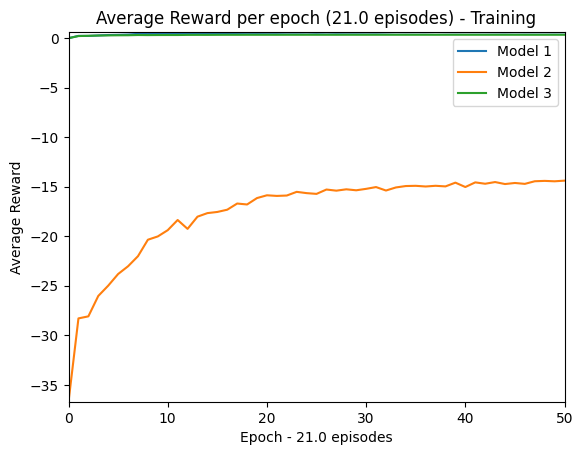

In [ ]:
average_epoch_reward_1 = average_epoch_reward(callback_1.episode_rewards, epochs, sac_episodes)
average_epoch_reward_3 = average_epoch_reward(callback_3.episode_rewards, epochs, sac_episodes)

# I wanto to measure the difference wrt to the min of this which is tha absolute max
# in this way I have a comparisioin of how much in % the training improved

average_epoch_reward_1 = 1-average_epoch_reward_1/min(average_epoch_reward_1)
average_epoch_reward_3 = 1-average_epoch_reward_3/min(average_epoch_reward_3)

plt.plot(average_epoch_reward_1[0:epochs+1])
plt.plot(average_epoch_reward_2[0:epochs+1])
plt.plot(average_epoch_reward_3[0:epochs+1])
plt.legend(["Model 1", "Model 2", "Model 3"])
plt.title(f"Average Reward per epoch ({episodes} episodes) - Training")
plt.xlabel(f"Epoch - {episodes} episodes")
plt.ylabel("Average Reward")
plt.show()

# Comments on the figure:
# 0 represents the start or the worst average reward per epoch recieved
# The more a value increase the better is the training


In [ ]:
average_epoch_reward_1[0:epochs+1]/max(average_epoch_reward_1)

array([0.        , 0.3428299 , 0.33550346, 0.4054982 , 0.46750456,
       0.4948163 , 0.53861815, 0.63563025, 0.6067274 , 0.6552203 ,
       0.67391074, 0.6556211 , 0.7120766 , 0.73871744, 0.7494846 ,
       0.73993784, 0.77200776, 0.7787889 , 0.7911039 , 0.78823835,
       0.7987166 , 0.7994214 , 0.82260364, 0.82111585, 0.83672214,
       0.8092198 , 0.83632004, 0.8116122 , 0.82473236, 0.82576525,
       0.83549535, 0.829575  , 0.85297936, 0.87855375, 0.8695137 ,
       0.8763746 , 0.87478524, 0.89505136, 0.8800195 , 0.87159187,
       0.8809264 , 0.876878  , 0.8762363 , 0.86923224, 0.86193967,
       0.87582433, 0.86425906, 0.8680233 , 0.8715152 , 0.86411065,
       0.8744901 ], dtype=float32)

### Testing

In [ ]:
sac_env_3_test = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=TESTING_START_TIME_STEP,
    simulation_end_time_step=TESTING_END_TIME_STEP,
    reward_function=AdaptiveWeightReward,
    episode_time_steps=EPISODE_TIME_STEPS,
)
sac_env_3_test = NormalizedObservationWrapper(sac_env_3_test)
sac_env_3_test = StableBaselines3Wrapper(sac_env_3_test)



In [ ]:
sac_action_list = []
reward_list = []
counter_steps = 0
while not sac_env_3_test.unwrapped.terminated:
    actions, _ = sac_model_3.predict(observations,
                                   deterministic=True)
    observations, reward,_,_,_ = sac_env_3_test.step(actions)
    sac_action_list.append(actions)
    reward_list.append(reward)
    counter_steps = counter_steps + 1

    if counter_steps%50==0:
      print(actions)
      print(observations)

print(counter_steps)

23


In [ ]:
from google.colab import output
def notif():
  output.eval_js('new Audio("https://notificationsounds.com/message-tones/appointed-529/download/mp3").play()')

# DDPG Simulation

In [ ]:
ddpg_env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=TRAINING_START_TIME_STEP,
    simulation_end_time_step=TRAINING_END_TIME_STEP,
    reward_function=CustomReward,
    episode_time_steps=EPISODE_TIME_STEPS
)

## Wrappers to adapt the environment to SB3.


In [ ]:
import numpy as np
import gymnasium as gym

class FlattenObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

        original_space = env.observation_space

        if isinstance(original_space, list):
            # Handle list of spaces (like CityLearn pre-SB3 wrappers)
            total_size = sum(np.prod(space.shape) for space in original_space)
            self.observation_space = gym.spaces.Box(
                low=-np.inf, high=np.inf, shape=(total_size,), dtype=np.float32
            )
        elif isinstance(original_space, gym.spaces.Box):
            # Already flattened
            self.observation_space = original_space
        else:
            raise ValueError(f"Unsupported observation_space type: {type(original_space)}")

    def observation(self, obs):
        if isinstance(obs, list):
            # Handle list of obs per building
            flat_obs = np.concatenate([np.array(o).flatten() for o in obs])
            return flat_obs
        else:
            # Already a flat vector
            return np.array(obs).flatten()

class FlattenActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)

        assert isinstance(env.action_space, list), "Expected list of action spaces"

        # Store original action spaces
        self.original_action_spaces = env.action_space

        # Calculate total action dimension
        low = []
        high = []
        for space in self.original_action_spaces:
            assert isinstance(space, gym.spaces.Box), "Only Box spaces are supported"
            low.append(space.low.flatten())
            high.append(space.high.flatten())

        low = np.concatenate(low)
        high = np.concatenate(high)

        self.action_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)

    def action(self, action):
        # Convert flat action back to list of arrays for each building
        split_dims = [np.prod(space.shape) for space in self.original_action_spaces]
        split_actions = np.split(action, np.cumsum(split_dims)[:-1])
        reshaped_actions = [
            a.reshape(space.shape) for a, space in zip(split_actions, self.original_action_spaces)
        ]
        return reshaped_actions

class AggregateRewardWrapper(gym.RewardWrapper):
    def __init__(self, env, mode='sum'):
        super().__init__(env)
        assert mode in ['sum', 'mean'], "mode must be 'sum' or 'mean'"
        self.mode = mode

    def reward(self, reward):
        if isinstance(reward, list):
            if self.mode == 'sum':
                return sum(reward)
            elif self.mode == 'mean':
                return sum(reward) / len(reward)
        return reward  # already scalar

## Model training

In [ ]:
# Let's wrap it
# First apply all gym-compatible wrappers
ddpg_env = NormalizedObservationWrapper(ddpg_env)
ddpg_env = FlattenObservationWrapper(ddpg_env)
ddpg_env = FlattenActionWrapper(ddpg_env)
ddpg_env = AggregateRewardWrapper(ddpg_env)
# Then wrap it for Stable Baselines3 compatibility
dddpg_env = StableBaselines3Wrapper(ddpg_env)

In [ ]:
# Prepare the model
ddpg_model = DDPG(policy='MlpPolicy', env=ddpg_env,seed=RANDOM_SEED, verbose=0)


In [ ]:
callback_3 = AverageRewardCallback(verbose=0)

In [ ]:
print(epochs, sac_episodes, sac_episode_timesteps)
print(sac_total_timesteps)

In [ ]:
ddpg_env.reset()

start_time = time.perf_counter()
for epoch in tqdm(range(epochs)):
  for ii in (range(int(sac_episodes))):
    ddpg_model.learn(
        total_timesteps=sac_episode_timesteps,
        reset_num_timesteps=False,
        callback=callback_3,
  )
elapsed_big = time.perf_counter() - start_time
print("Tutorial training time: ", elapsed_big)

In [ ]:
average_epoch_reward_1 = average_epoch_reward(callback_1.episode_rewards, epochs, sac_episodes)
average_epoch_reward_2 = average_epoch_reward(callback_2.episode_rewards, epochs, sac_episodes)
average_epoch_reward_3 = average_epoch_reward(callback_3.episode_rewards, epochs, sac_episodes)
print("This is first model ",len(callback_1.episode_rewards))
print("This is second model ", len(callback_2.episode_rewards))

print(len(average_epoch_reward_1))
print(len(average_epoch_reward_2))


plt.plot(average_epoch_reward_1[0:epochs+1])
plt.plot(average_epoch_reward_2[0:epochs+1])
plt.plot(average_epoch_reward_3[0:epochs+1])
plt.legend(["Model 1", "Model 2", "DDPG"])
plt.title(f"Average Reward per epoch ({episodes} episodes) - Training")
plt.xlabel(f"Epoch - {episodes} episodes")
plt.ylabel("Average Reward")
plt.show()


In [ ]:
plt.plot(callback_1.episode_rewards)
plt.plot(callback_2.episode_rewards)
plt.plot(callback_3.episode_rewards)
plt.title("Reward per episode")
plt.xlabel("Episode")
plt.ylabel("Reward per episode")
plt.show()

## Evaluation of the algorithm

In [ ]:
#--- TEST ENVIRONMENT ---
ddpg_test_env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=TESTING_START_TIME_STEP,
    simulation_end_time_step=TESTING_END_TIME_STEP,
    reward_function=CustomReward,
)

In [ ]:
#--- WRAP ENV FOR TESTING ---
ddpg_test_env = NormalizedObservationWrapper(ddpg_test_env)
ddpg_test_env = FlattenObservationWrapper(ddpg_test_env)
ddpg_test_env = FlattenActionWrapper(ddpg_test_env)
ddpg_test_env = AggregateRewardWrapper(ddpg_test_env)
# Then wrap it for Stable Baselines3 compatibility
dddpg_env = StableBaselines3Wrapper(ddpg_test_env)

In [ ]:
# Evaluation of the model
observations, _ = ddpg_test_env.reset()
ddpg_action_list = []
cumulative_reward_list = []
cumulative_reward = 0

while not ddpg_test_env.unwrapped.terminated:
  actions, _ = ddpg_model.predict(observations,
                                  deterministic = True)
  observations, reward, _,_,_ = ddpg_test_env.step(actions)
  ddpg_action_list.append(actions)
  cumulative_reward = cumulative_reward + reward
  cumulative_reward_list.append(cumulative_reward)

# Plot the summary
plot_simulation_summary({
    'Baseline': baseline_env,
    'SAC': sac_env,
    'DDPG': ddpg_test_env
})

# Plot the reward
